# 0.0. Import 

In [9]:
import math
import pandas as pd
import inflection 
import numpy as np
import seaborn as sns
import xgboost as xgb
import random
import pickle
import json

from scipy import stats as ss
from boruta import BorutaPy
from sklearn.linear_model import LinearRegression, Lasso

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

from matplotlib import pyplot as plt
from IPython.core.display import HTML

## 0.1 Helper Func


In [12]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
    
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n =cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    
    return np.sqrt((chi2/n) / (min (k-1, r-1)))


def m1_error(model_name, y, yhat):
    mae =  mean_absolute_error(y, yhat)
    mape = (mean_absolute_percentage_error(y,yhat))
    rsme = np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame({ 'Model Name': model_name,
                            'MAE': mae,
                            'MAPE': mape,
                            'RSME': rsme}, index=[0])



def cross_validation(x_training, kfold, model_name, model, verbose= False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range (1, kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
        #Start and End Date for Validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        #filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date)& (x_training['date'] <= validation_end_date)]

        #training and validation dataset

        #training
        xtraining = training.drop(['date','sales'], axis=1)
        ytraining = training['sales']


        #validation
        xvalidation=validation.drop(['date','sales'], axis=1)
        yvalidation=validation['sales']

        #model
        m = model.fit( xtraining, ytraining)

        #prodection
        yhat= m.predict(xvalidation)

        #performace and store of each kfold iteration
        m_result = m1_error( model_name, np.expm1(yvalidation), np.expm1(yhat))
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RSME'])

    return pd.DataFrame({'Model Name': model_name,
        'MAE CV': np.round( np.mean(mae_list),2).astype(str)+ ' +/- ' + np.round( np.std(mae_list),2).astype(str),
        'MAPE CV': np.round( np.mean(mape_list),2).astype(str)+ ' +/- ' + np.round( np.std(mape_list),2).astype(str),
        'RSME CV': np.round( np.mean(rmse_list),2).astype(str)+ ' +/- ' + np.round( np.std(rmse_list),2).astype(str)}, index=[0])



In [13]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading data


In [17]:
df_sales_raw = pd.read_csv ('../rossmann-store-sales/train.csv', low_memory=False)
df_store_raw = pd.read_csv ('../rossmann-store-sales/store.csv', low_memory=False)

#merge
df_raw = pd.merge( df_sales_raw,df_store_raw, how='left', on='Store')

# 1.0 Descriçao de Dados

In [18]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear',
            'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list(map(snakecase, cols_old))

#Rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [7]:
print('Number of Rows: {}' .format(df1.shape[0]))
print('Number of Columns: {}' .format(df1.shape[1]))

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Type

In [8]:
#Mudando DateTime
df1['date'] = pd.to_datetime(df1['date'])

#DataTypes
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [9]:
#checking Na
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fill out NA

In [10]:
df1['competition_distance'].max()

df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
168310,1061,2,2015-03-03,7647,530,1,1,0,0,d,c,8110.0,NaN,NaN,0,NaN,NaN,NaN


In [11]:
#competition_distance    
df1['competition_distance'] = df1['competition_distance'].apply (lambda x: 200000.0 if math.isnan(x) else x)
                                                              
#competition_open_since_month
df1['competition_open_since_month'] = df1.apply (lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year   
df1['competition_open_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week 
df1['promo2_since_week'] = df1.apply (lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year  
df1['promo2_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval 
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Ago', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [12]:
#checking NA
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Dtypes

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statiscal

In [14]:
num_attribute = df1.select_dtypes (include=['int64', 'float64'])
cat_attribute = df1.select_dtypes (exclude=['int64', 'float64','datetime64[ns]'])

## 1.7.1 Numerical Statiscal

In [15]:
#Central Tendency - mean, median 
ct1 = pd.DataFrame(num_attribute.apply(np.mean)).T
ct2 = pd.DataFrame(num_attribute.apply(np.median)).T

#Dispersion - std, min, max, range, skew, kurtosis

d1 = pd.DataFrame(num_attribute.apply(np.std)).T
d2 = pd.DataFrame(num_attribute.apply(min)).T
d3 = pd.DataFrame(num_attribute.apply(max)).T
d4 = pd.DataFrame(num_attribute.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attribute.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attribute.apply(lambda x: x.kurtosis())).T
                  
#concat
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes' ,'min' ,'max' ,'range' ,'mean' ,'median' ,'std' ,'skew' ,'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.147947,0.0,0.355047,1.983135,1.932829


C:\Users\Lima\Anaconda3\envs\Rossmann-Store-Predict-Env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

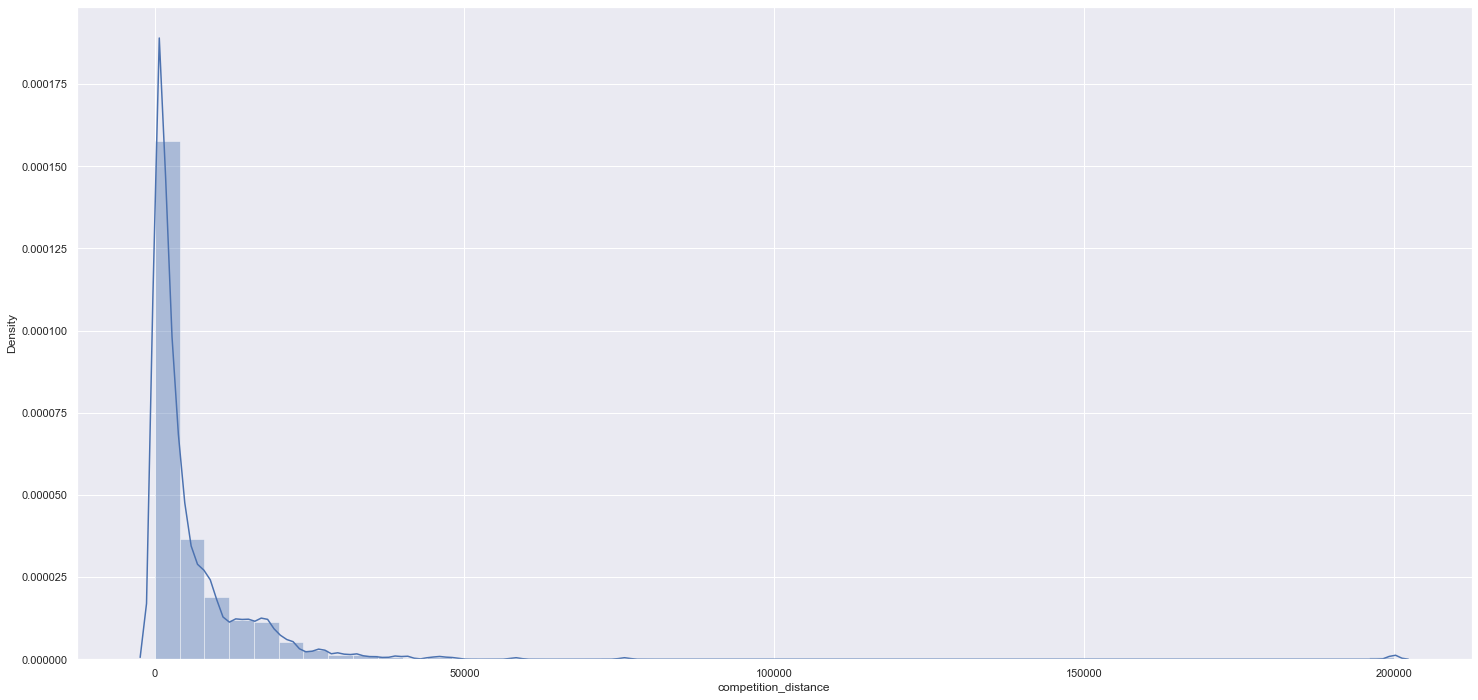

In [16]:
sns.distplot(df1['competition_distance'])

## 1.7.2 Categorical Statiscal

In [17]:
cat_attribute.apply( lambda x: x.unique().shape[0])

state_holiday                    4
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_map                       12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

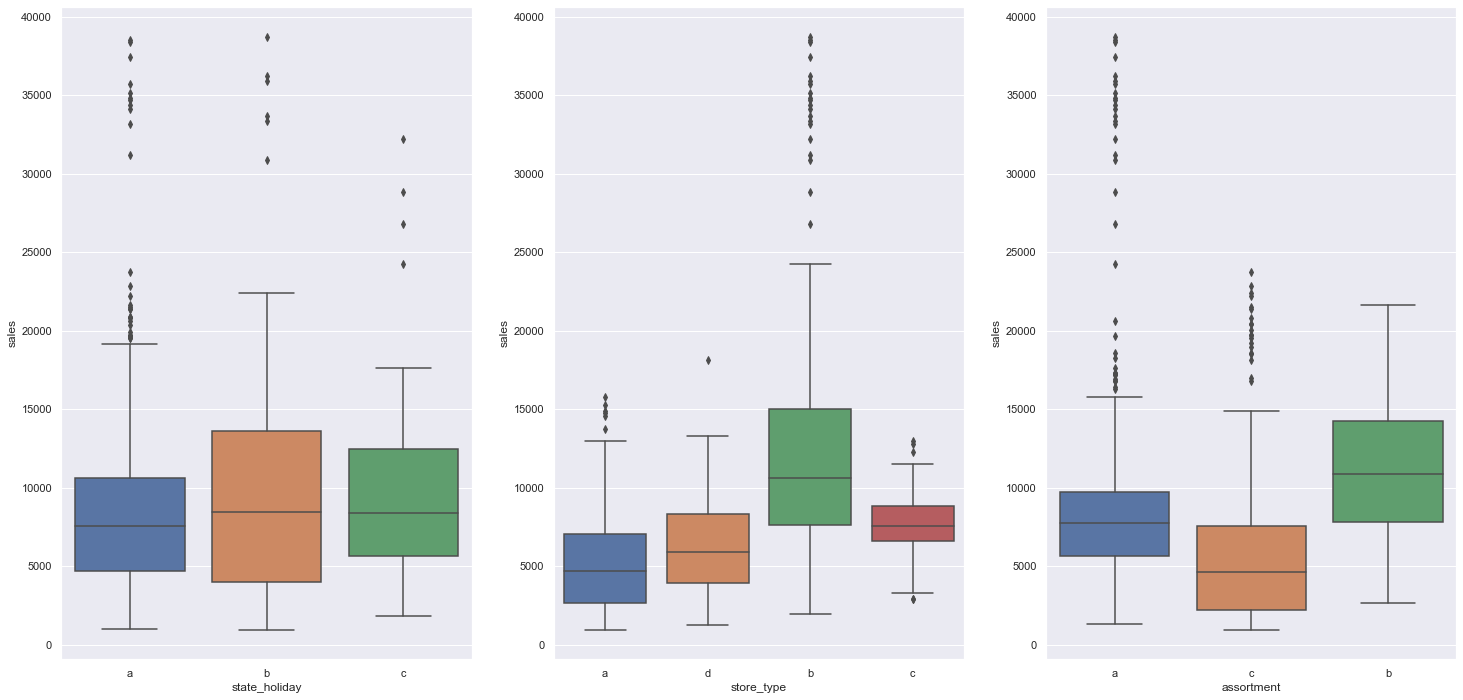

In [18]:
aux1 = df1[(df1['state_holiday'] != '0' ) & (df1['sales']>0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales' ,  data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales' ,  data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales' ,  data=aux1)

# 2.0 Criacao de Hipoteses

In [19]:
df2 = df1.copy()

## 2.1.1 Hipoteses Loja

**1.** Lojas com Maior Quadro de Funcionarios, deveriam vender mais.

**2.** Lojas com Maior Estoque, deveriam Vender mais.

**3** Lojas com Maior Porte, deveriam vender mais.

**4** Lojas com menor Porte, deveriam vender menos.

**5** Lojas com maior sortimento, deveriam vender mais.

## 2.1.2 Hipoteses Produto

**1.** Lojas que investem mais em Marketing, deveriam vender mais.

**2.** Lojas que Expoem mais o Produto nas Vitrine, deveriam vender mais.

**3.** Lojas que tem precos menores nos produtos, deveriam vender mais.

**4.** Lojas que tem precos menores em mais tempo, deveriam vender mais.

## 2.1.3 Hipoteses Tempo

**1.** Lojas que tem mais possuem mais Feriado, deveriam vender menos.

**2.** Lojas que abrem no primeiro 6m, deveriam vender mais

**3.** Lojas que abrem nos finais de semana, deveriam vender mais.

## 2.3. Lista Final de Hipoteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4. Feature Engineering

In [20]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], 
                                                                  month=x['competition_open_since_month'],day=1 ), axis=1 )

df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' 
                                                  else 'christmas' if x == 'c' else 'regular_day' )


<ipython-input-20-c4fd6667efd9>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


# 3.0. Filtragem de Variaveis

In [21]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas

In [22]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Selecao das Colunas

In [23]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

In [24]:
df3.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


# 4.0  Analise Exploratoria do Dados

In [25]:
df4 = df3.copy()

## 4.1 - Analise Univariada

### 4.1.1 - Response Variable

C:\Users\Lima\Anaconda3\envs\Rossmann-Store-Predict-Env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

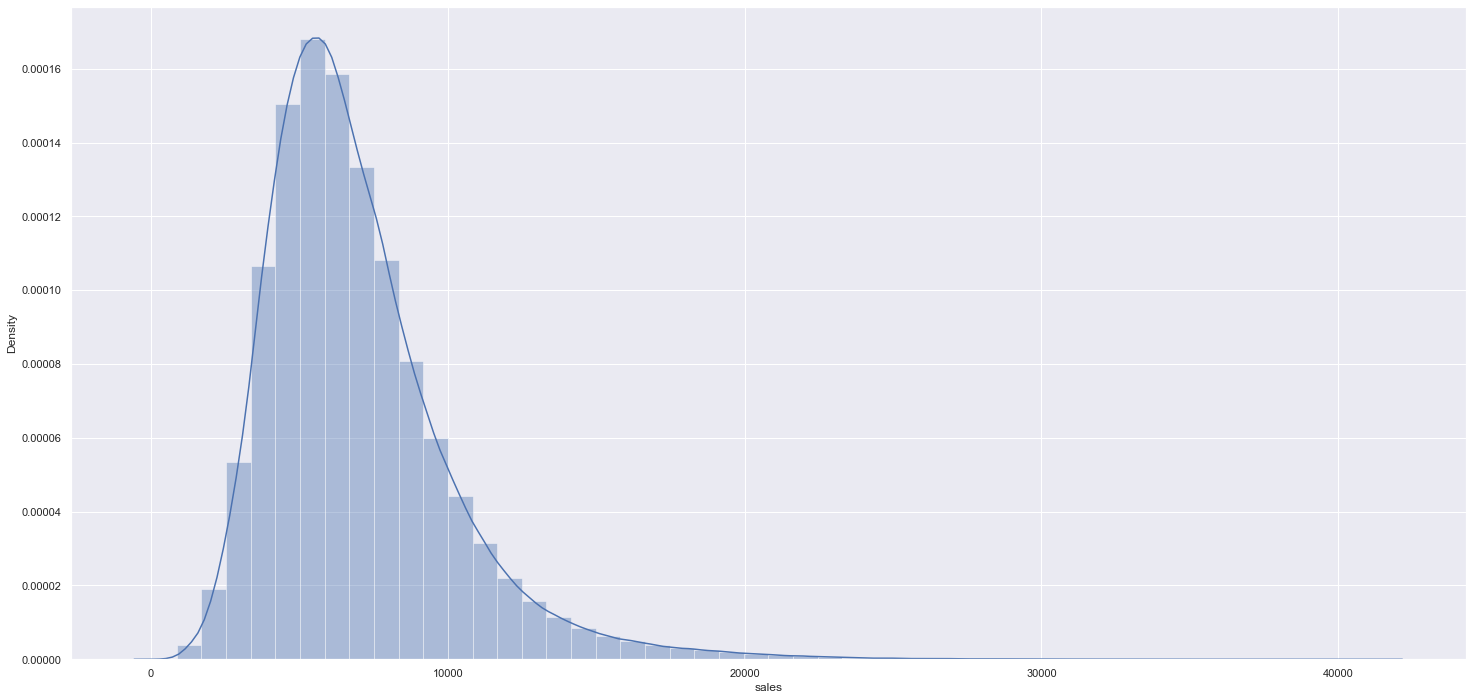

In [26]:
sns.distplot(df4['sales'])

### 4.1.2 - Numerical Variable

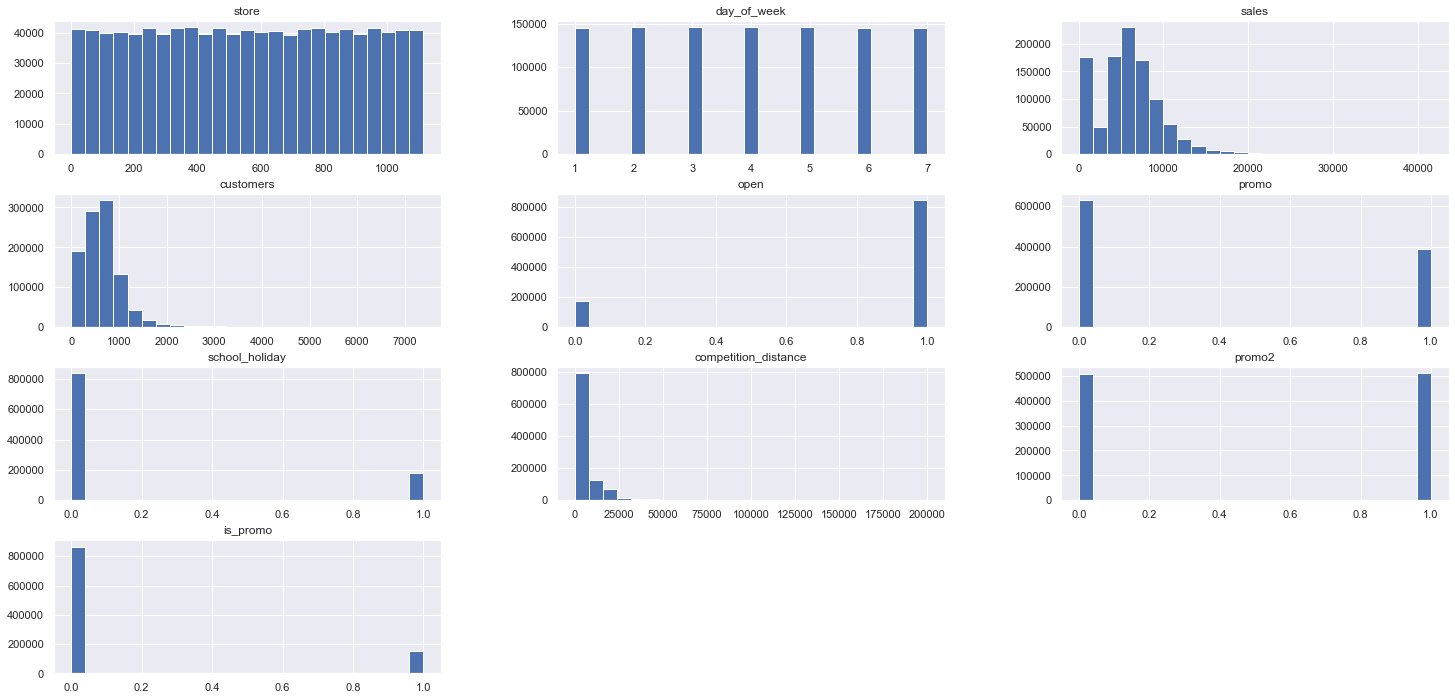

In [27]:
num_attribute.hist(bins=25);

### 4.1.3 - Categorical Variable

In [28]:
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

C:\Users\Lima\Anaconda3\envs\Rossmann-Store-Predict-Env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Lima\Anaconda3\envs\Rossmann-Store-Predict-Env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Lima\Anaconda3\envs\Rossmann-Store-Predict-Env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword w

<AxesSubplot:xlabel='sales', ylabel='Density'>

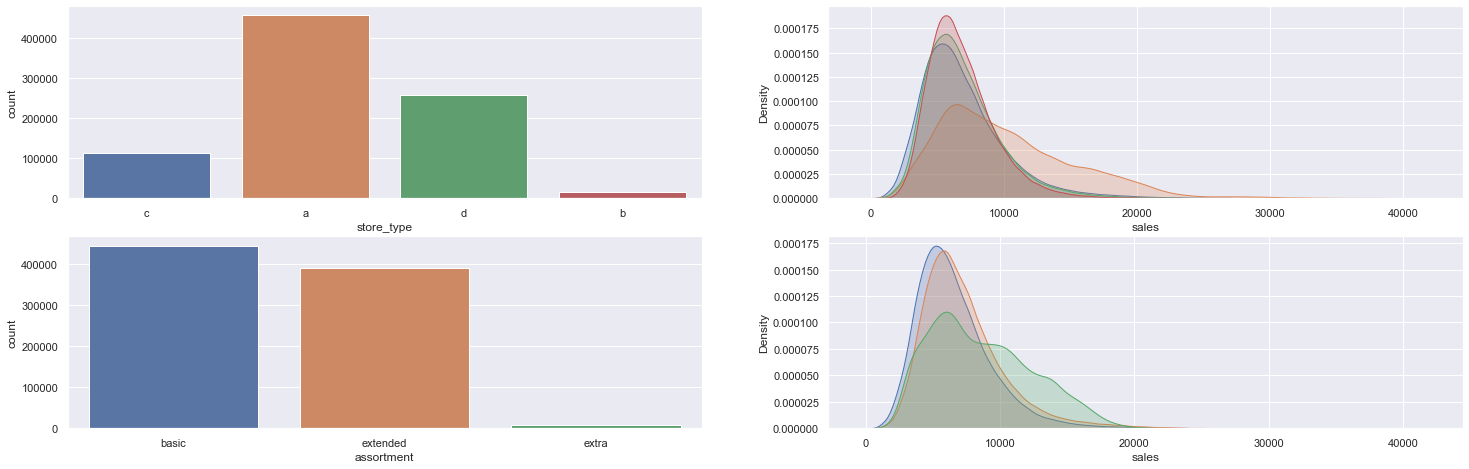

In [29]:
#state_holiday
plt.subplot(2,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(2,2,2)
sns.kdeplot (df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot (df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot (df4[df4['state_holiday'] == 'christmas']['sales'],  label='christmas', shade=True)

#store_type

plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot (df4[df4['store_type'] == 'a']['sales'],  label='a', shade=True)
sns.kdeplot (df4[df4['store_type'] == 'b']['sales'],  label='b', shade=True)
sns.kdeplot (df4[df4['store_type'] == 'c']['sales'],  label='c', shade=True)
sns.kdeplot (df4[df4['store_type'] == 'd']['sales'],  label='d', shade=True)

#assortment

plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot (df4[df4['assortment'] == 'basic']['sales'],  label='basic', shade=True)
sns.kdeplot (df4[df4['assortment'] == 'extended']['sales'],  label='extended', shade=True)
sns.kdeplot (df4[df4['assortment'] == 'extra']['sales'],  label='extra', shade=True)

## 4.2 - Analise Bivariada

### H1. Lojas com maior sortimentos deveriam vender mais.

False: Lojas com maior sortimentos vendem menos

<AxesSubplot:xlabel='year_week'>

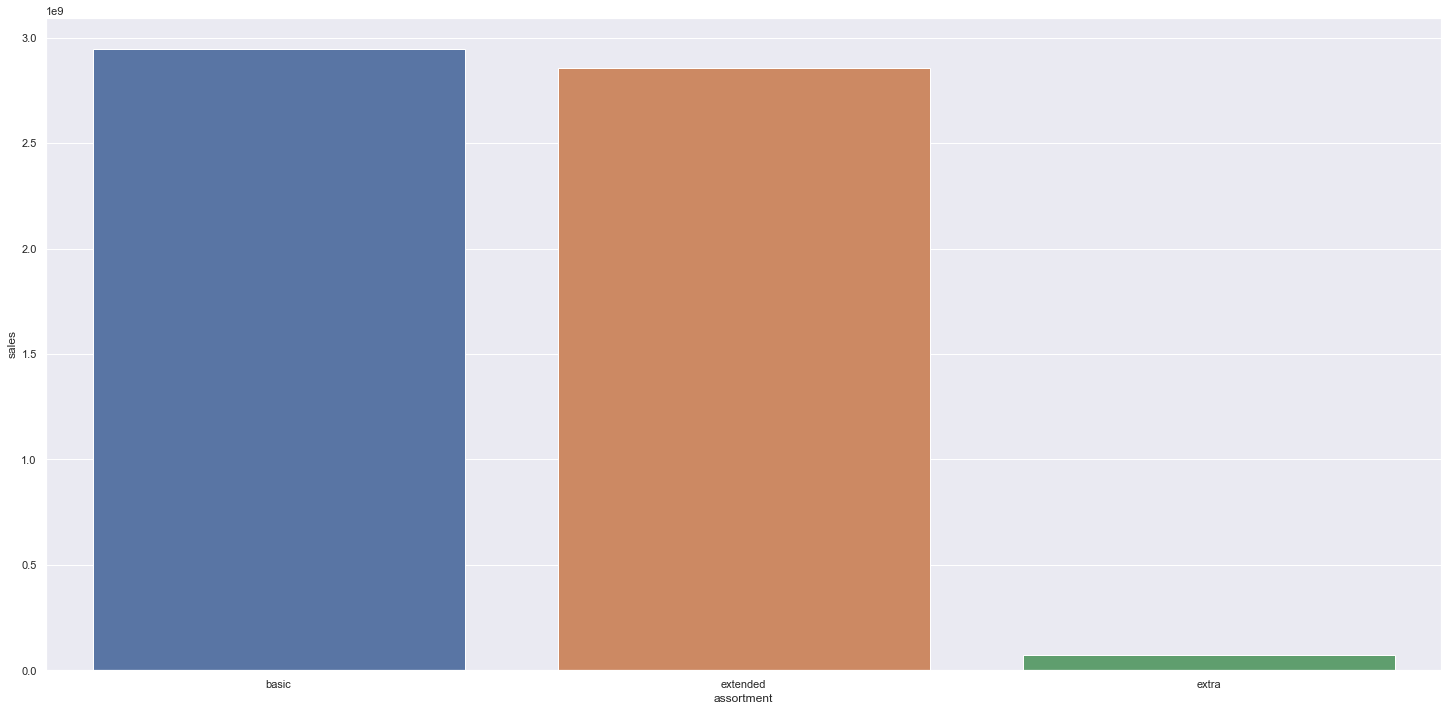

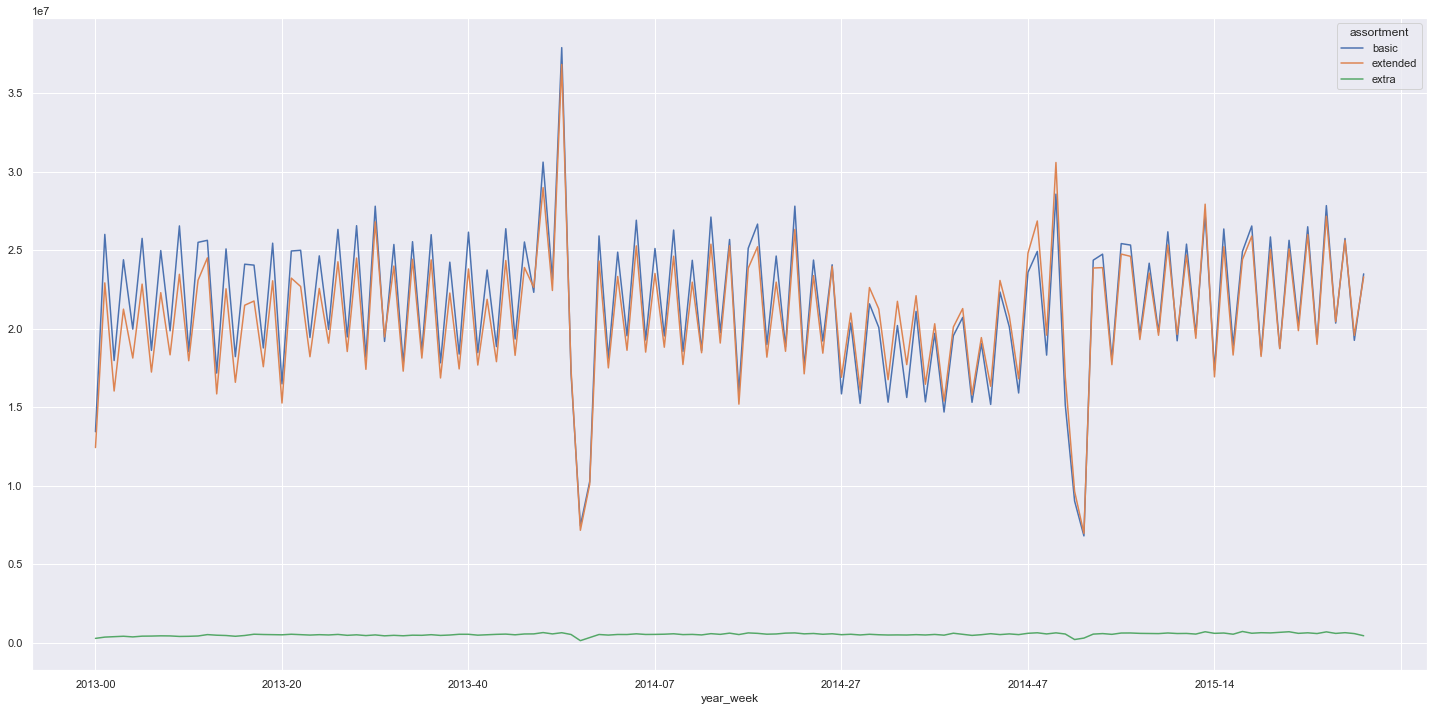

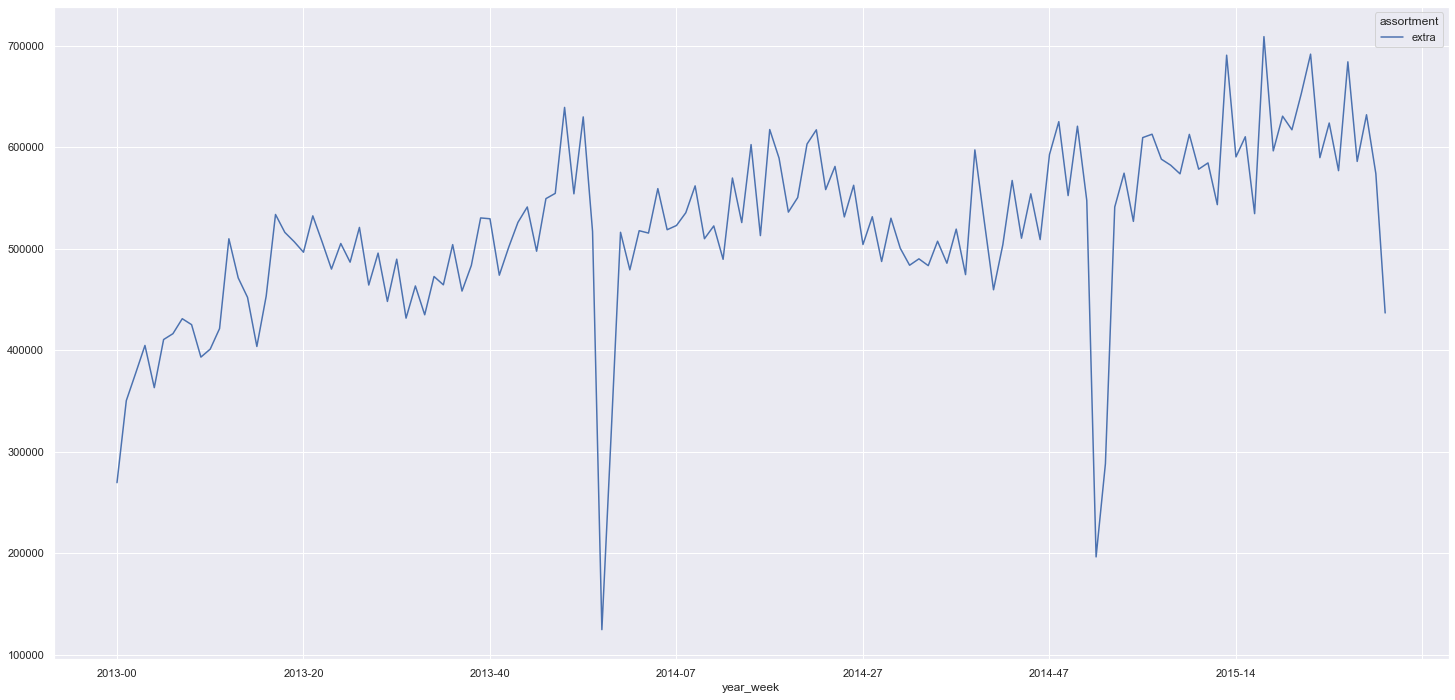

In [30]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot( x='assortment' , y='sales', data=aux1);

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot( index='year_week'  , columns='assortment' , values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week'  , columns='assortment' , values='sales').plot()

### H2. Lojas com competidores mais próximos deveriam vender menos.

False- Lojas com COMPETIDORES MAIS PROXIMOS, vendem MAIS

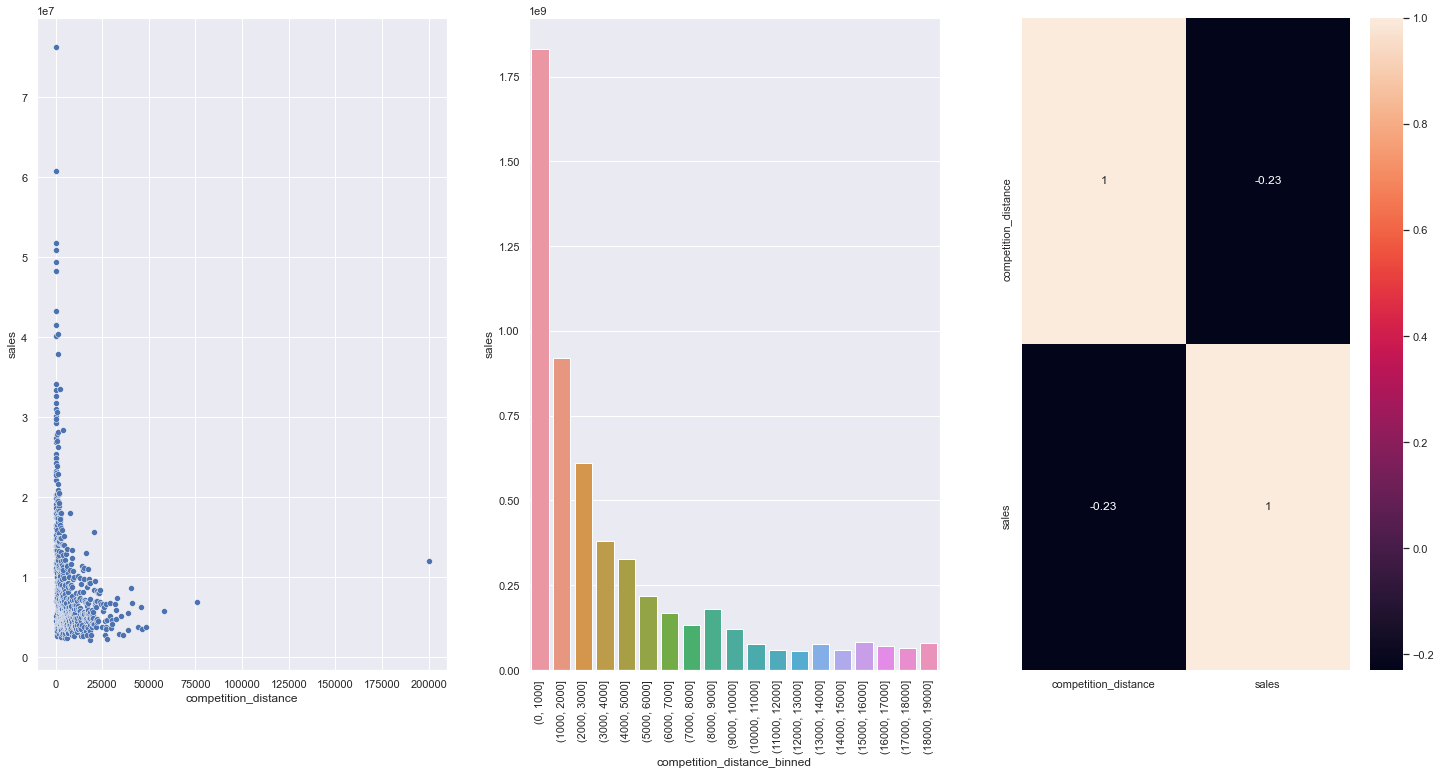

In [31]:
aux1= df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot(1,3,2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2= aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot( x='competition_distance_binned' , y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### H3 Lojas com competidores à mais tempo deveriam vendem mais.

False:  Lojas com Competidores a MAIS TEMPOS, VENDEM a MENOS

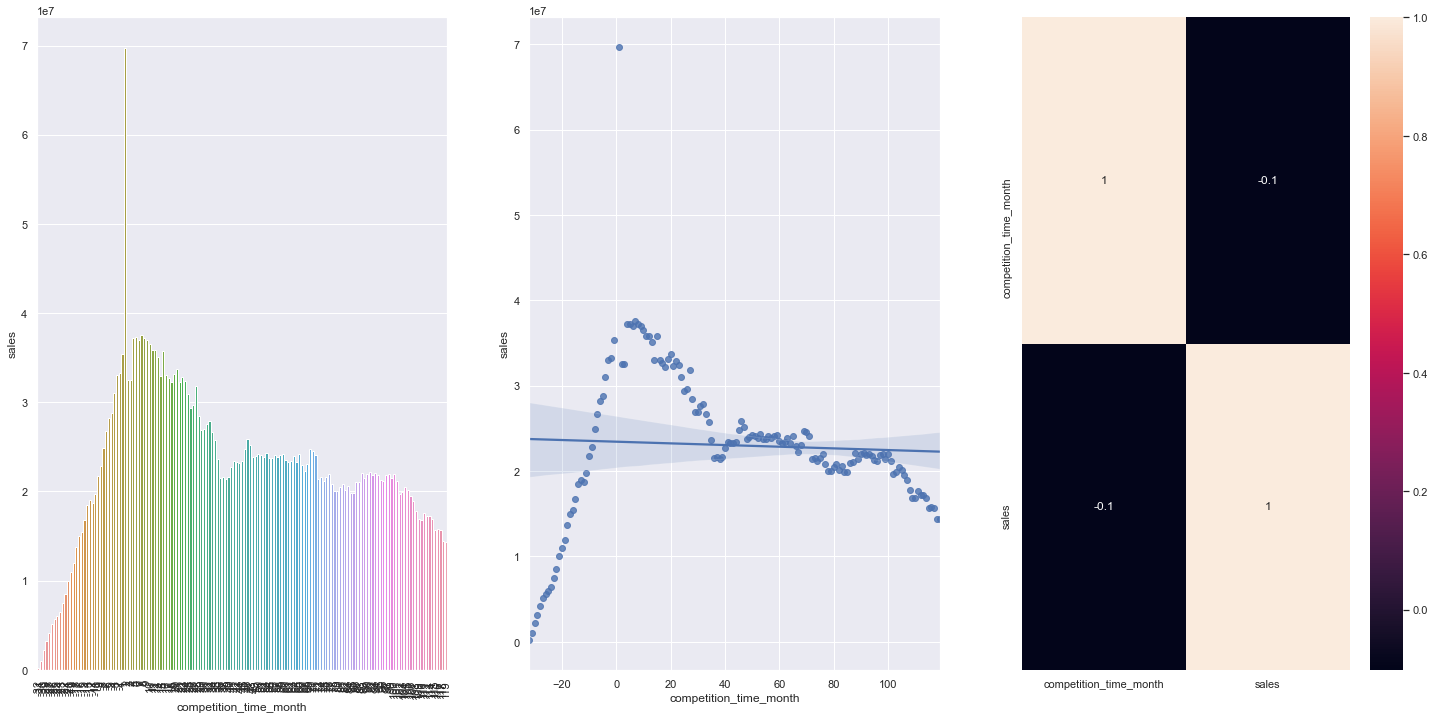

In [32]:
plt.subplot(1,3,1)
aux1= df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot (x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot (x='competition_time_month', y='sales', data=aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.

Falsa, lojas com promocoes ativas VENDEM MENOS, depois de um PERIODO DE PROMOCAO

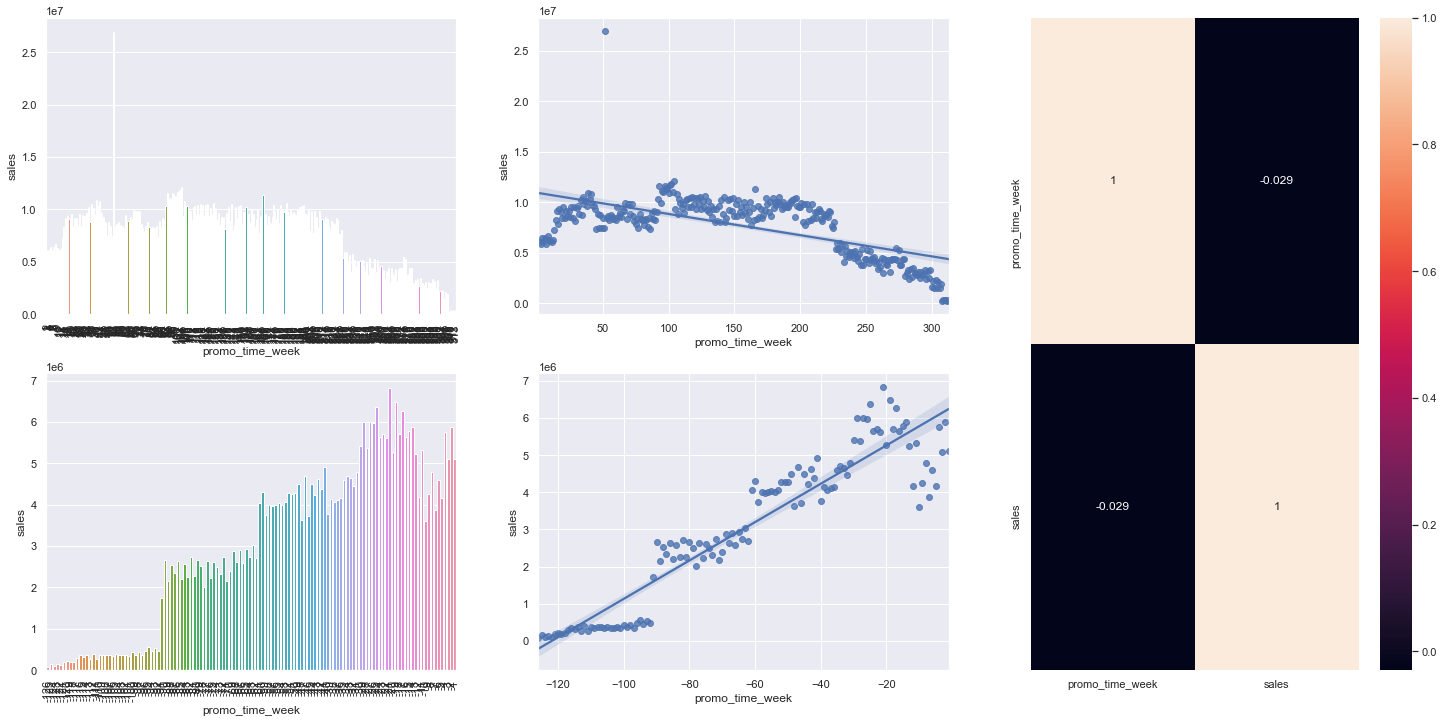

In [33]:
aux1= df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()


grid = GridSpec(2,3)

plt.subplot(grid[0,0]) 
aux2 = aux1[aux1['promo_time_week']> 0] #promo extendido
sns.barplot(x='promo_time_week',y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week',y='sales', data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week']< 0] #promo regular
sns.barplot(x='promo_time_week',y='sales', data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week',y='sales', data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr( method='pearson'), annot=True);



### H5. Lojas com mais dias de promoção deveriam vender mais.

### H6. Lojas com mais promoções consecutivas deveriam vender mais.

Falsa, lojas com MAIS PROMOCOES EXTENDIDAS, VENDEM MENOS

In [34]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


### H8. Lojas abertas durante o feriado de Natal deveriam vender mais.

Falsa, não vende mais.

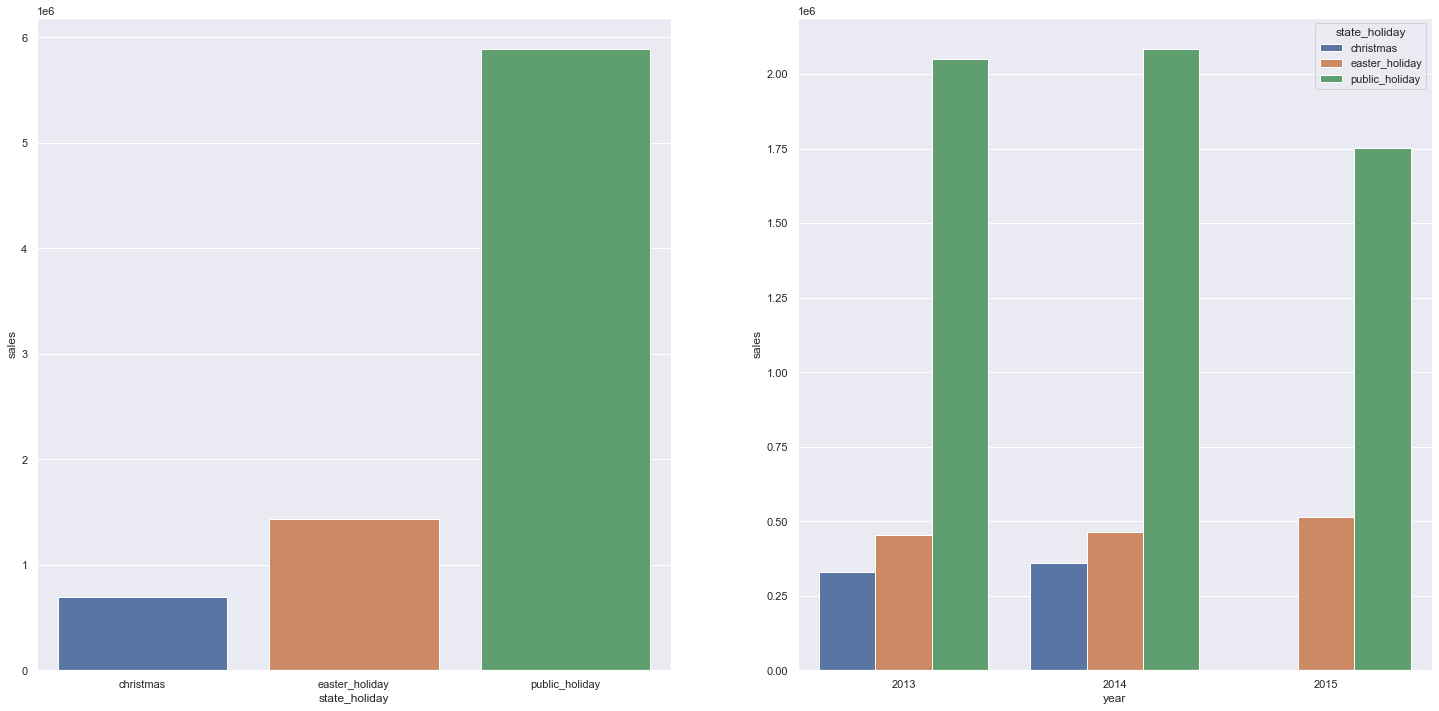

In [35]:
plt.subplot(1,2,1)
aux = df4[df4['state_holiday']!= 'regular_day']
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales', data=aux1);

plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);


### H9. Lojas deveriam vender mais ao longo dos anos.

Falsa, Lojas vendem menos

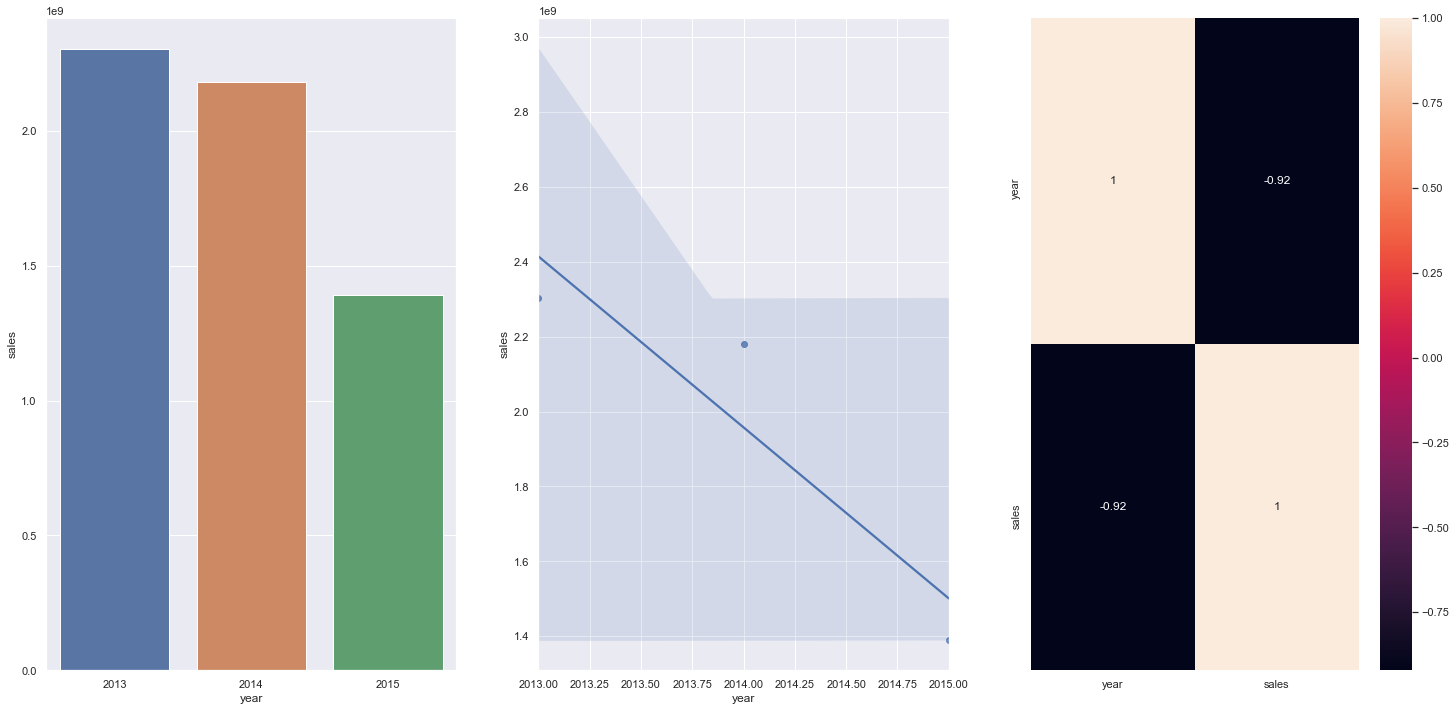

In [36]:
aux3 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux3);

plt.subplot(1,3,2)
sns.regplot(x='year', y='sales', data=aux3);

plt.subplot(1,3,3)
sns.heatmap(aux3.corr(method ='pearson'), annot=True);


### H10. Lojas deveriam vender mais no segundo semestre do ano.

FALSA, As lojas vendem menos no 2. Semestre

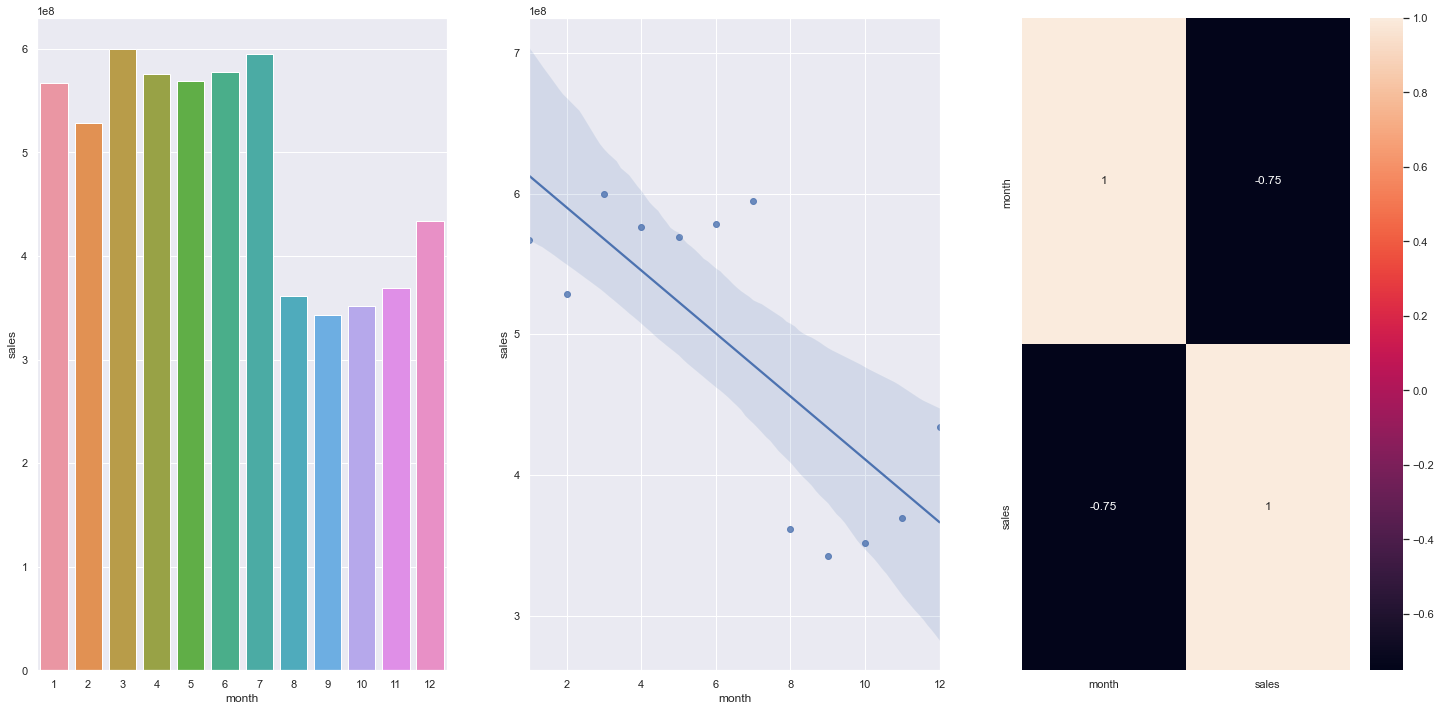

In [37]:
aux3 = df4[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux3);

plt.subplot(1,3,2)
sns.regplot(x='month', y='sales', data=aux3);

plt.subplot(1,3,3)
sns.heatmap(aux3.corr(method ='pearson'), annot=True);


###  11. Lojas deveriam vender mais depois do dia 10 de cada mês.
 Verdadeira, porque as lojas VENDEM mais depois do dia 10

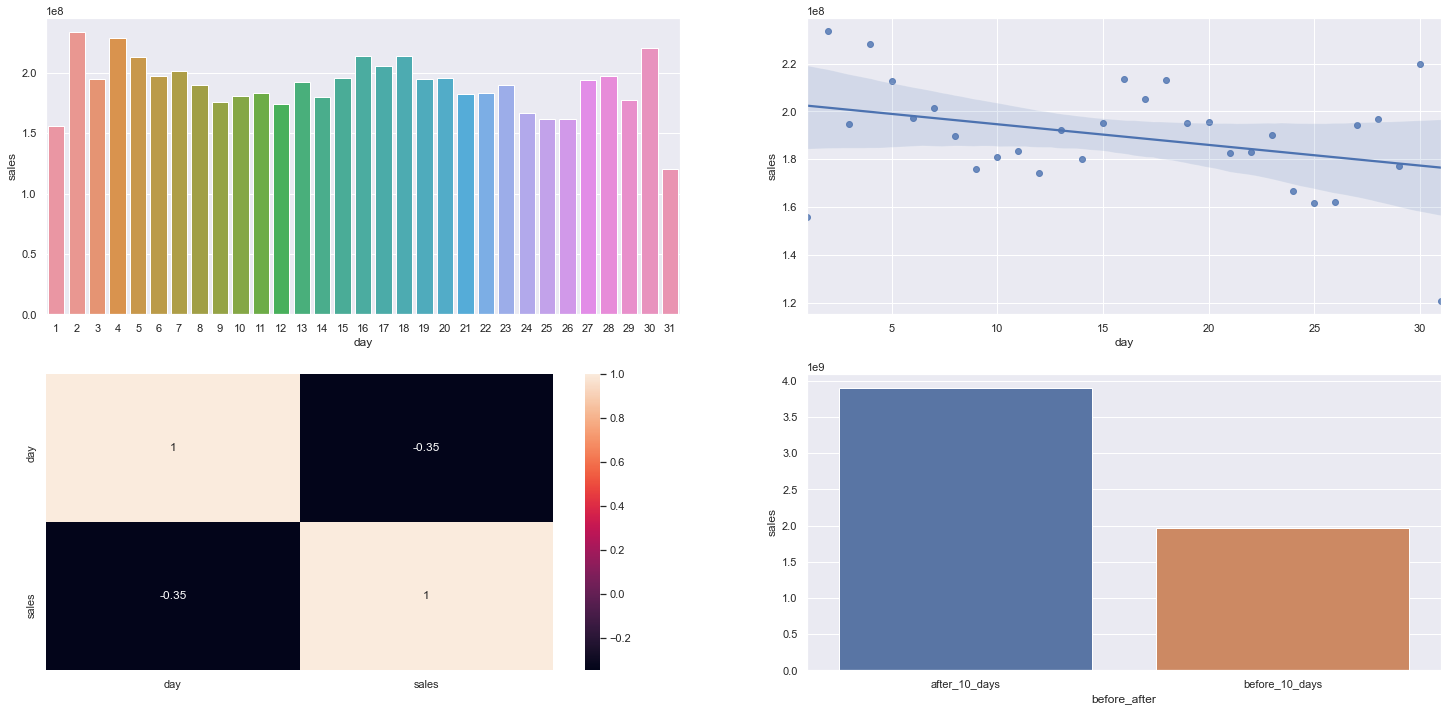

In [38]:
aux3 = df4[['day','sales']].groupby('day').sum().reset_index()

aux3['before_after'] = aux3['day'].apply (lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux4 = aux3[['before_after','sales']].groupby('before_after').sum().reset_index() 

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux3);

plt.subplot(2,2,2)
sns.regplot(x='day', y='sales', data=aux3);

plt.subplot(2,2,3)
sns.heatmap(aux3.corr(method ='pearson'), annot=True);

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux4);

### 12. Lojas deveriam vender menos aos finais de semana.

Verdadeira, loja vendem menos aos Finais de Semana

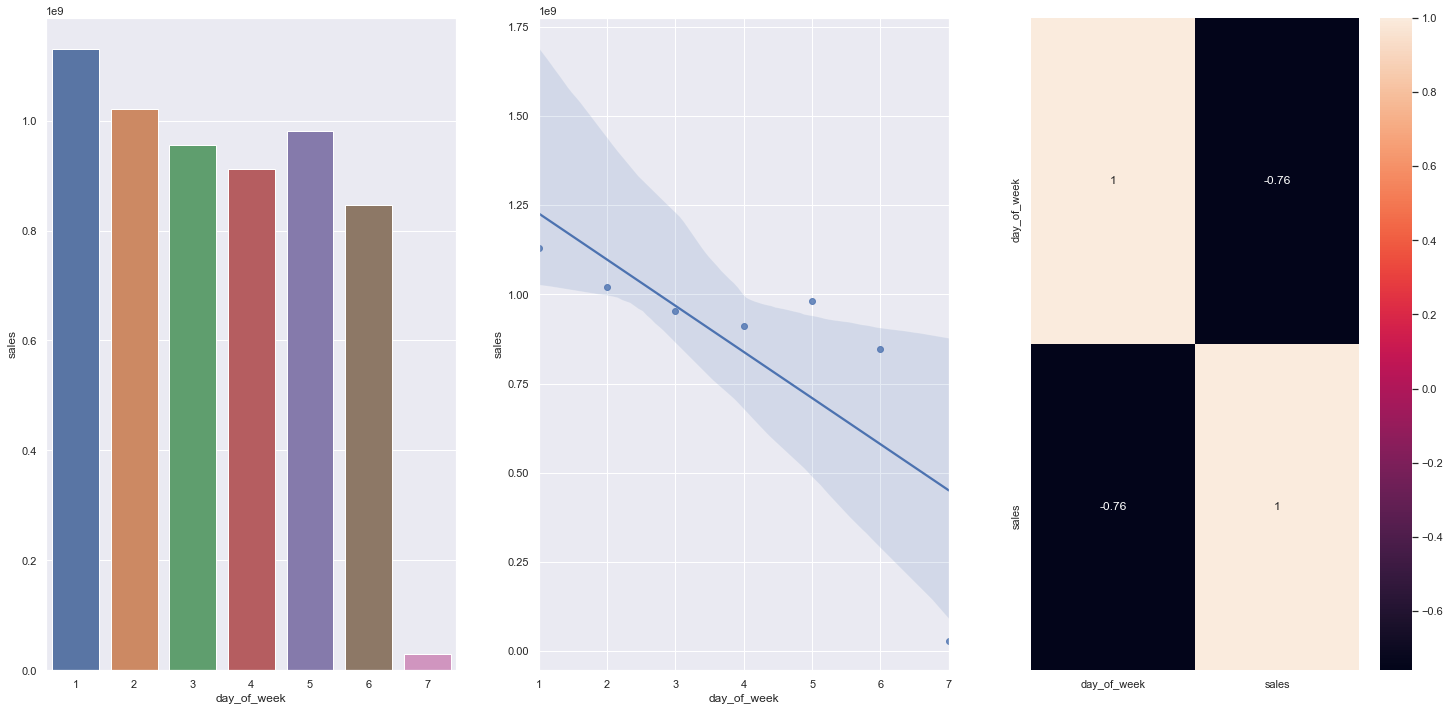

In [39]:
aux3 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux3);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week', y='sales', data=aux3);

plt.subplot(1,3,3)
sns.heatmap(aux3.corr(method ='pearson'), annot=True);


### 13. Lojas deveriam vender menos durante os feriados escolares.

Verdadeira - vendem menos durante as Feriados escolares, exceto Julho e Agosto

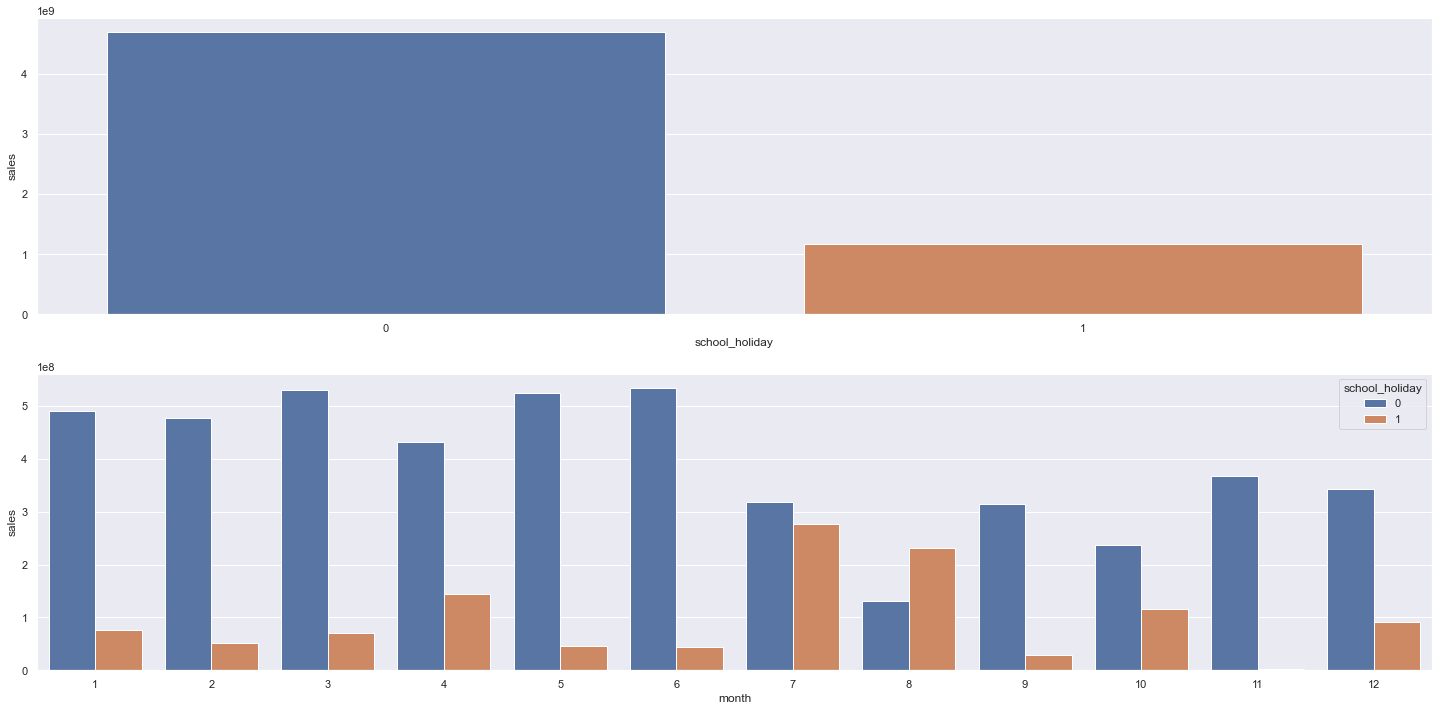

In [40]:
aux3 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='school_holiday', y='sales', data=aux3);

aux4 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux4);


## 4.3 - Analise Multivariada

### 4.3.1 Numerical Attributes

<AxesSubplot:>

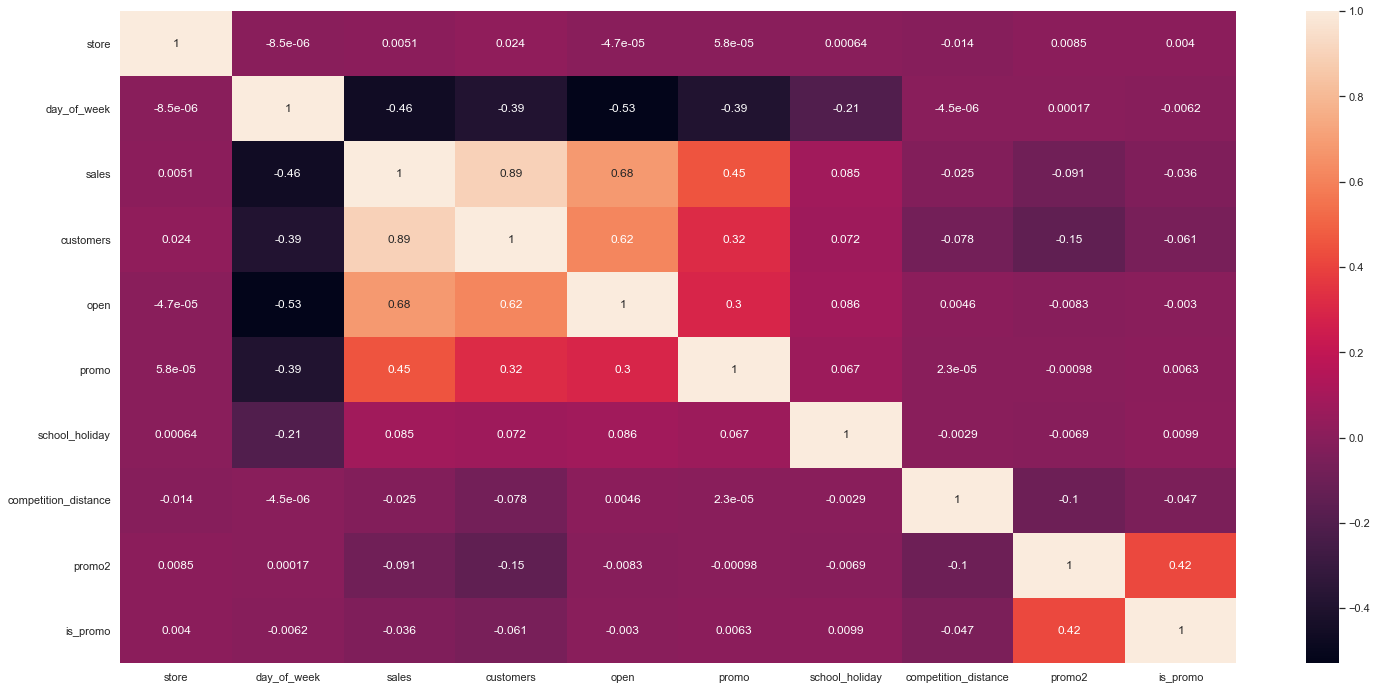

In [41]:
correlation = num_attribute.corr(method = 'pearson')
sns.heatmap(correlation, annot=True)

### 4.3.2 Categorical Attributes

In [42]:
a.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
63559,5,4,2015-06-04,5807,1,public_holiday,0,a,basic,29910.0,4,2015,0,23,2015,0,2015,6,4,23,2015-22,2015-04-01,2,2015-06-01,0
63560,6,4,2015-06-04,5749,1,public_holiday,0,a,basic,310.0,12,2013,0,23,2015,0,2015,6,4,23,2015-22,2013-12-01,18,2015-06-01,0
63609,55,4,2015-06-04,5984,1,public_holiday,0,a,basic,720.0,11,2004,0,23,2015,0,2015,6,4,23,2015-22,2004-11-01,128,2015-06-01,0
63611,57,4,2015-06-04,9301,1,public_holiday,0,d,extended,420.0,6,2014,0,23,2015,0,2015,6,4,23,2015-22,2014-06-01,12,2015-06-01,0
63614,60,4,2015-06-04,10399,1,public_holiday,0,d,extended,5540.0,10,2009,0,23,2015,0,2015,6,4,23,2015-22,2009-10-01,69,2015-06-01,0


<AxesSubplot:>

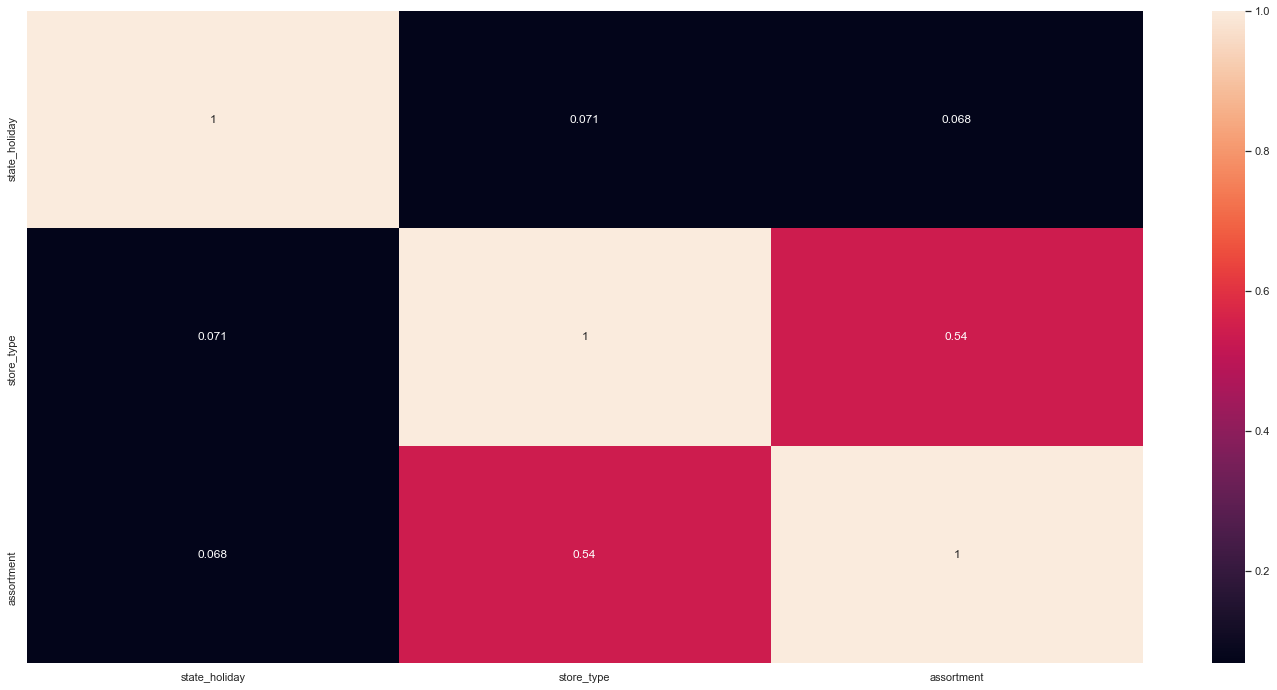

In [247]:
#only categorical Data
a = df4.select_dtypes(include=object)

#calculate cramer_v
a1= (cramer_v(a['state_holiday'], a['state_holiday']))
a2= (cramer_v(a['state_holiday'], a['store_type']))
a3= (cramer_v(a['state_holiday'], a['assortment']))

a4= (cramer_v(a['store_type'], a['state_holiday']))
a5= (cramer_v(a['store_type'], a['store_type']))
a6= (cramer_v(a['store_type'], a['assortment']))

a7= (cramer_v(a['assortment'], a['state_holiday']))
a8= (cramer_v(a['assortment'], a['store_type']))
a9= (cramer_v(a['assortment'], a['assortment']))

#final Dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3], 
               'store_type': [a4, a5, a6], 
               'assortment': [a7, a8, a9]})

d = d.set_index (d.columns)
#HeatMap
sns.heatmap (d, annot=True)

# 5.0  Data Preparation


In [44]:
df5 = df4.copy()

In [45]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 5.1 Normalization

Nao foi feito nenhuma Normalization.

## 5.2 Rescaling


In [46]:
a = df5.select_dtypes(include =['int64', 'float'])
a.dtypes

store                     int64
day_of_week               int64
sales                     int64
promo                     int64
school_holiday            int64
competition_distance    float64
promo2                    int64
is_promo                  int64
year                      int64
month                     int64
day                       int64
week_of_year              int64
dtype: object

C:\Users\Lima\Anaconda3\envs\Rossmann-Store-Predict-Env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='year'>

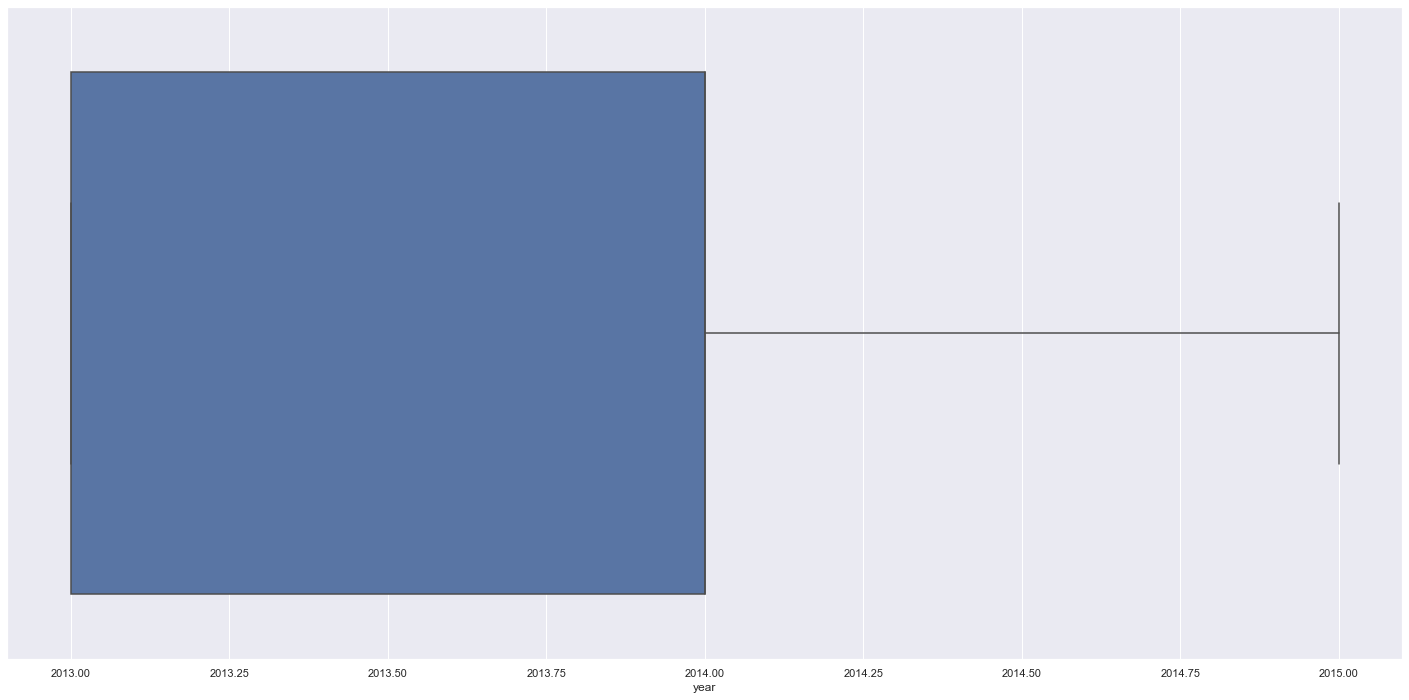

In [47]:
sns.boxplot( df5['year'])

In [69]:
rs = RobustScaler()
mms = MinMaxScaler()

#competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

##pickle.dump(rs, open('/Users/jefersonlima/Documents/GitHub/Rossmann-Store-Prediction/parameter/competition_distance_scaler.pkl', 'wb') ) 


#competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
##pickle.dump(rs, open('/Users/jefersonlima/Documents/GitHub/Rossmann-Store-Prediction/parameter/competition_time_month_scaler.pkl', 'wb') ) 


#promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
##pickle.dump(rs, open('/Users/jefersonlima/Documents/GitHub/Rossmann-Store-Prediction/parameter/promo_time_week_scaler.pkl', 'wb') ) 

#year
df5['year'] = mms.fit_transform(df5[['year']].values)
##pickle.dump(rs, open('/Users/jefersonlima/Documents/GitHub/Rossmann-Store-Prediction/parameter/year_scaler.pkl', 'wb') ) 



C:\Users\Lima\Anaconda3\envs\Rossmann-Store-Predict-Env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


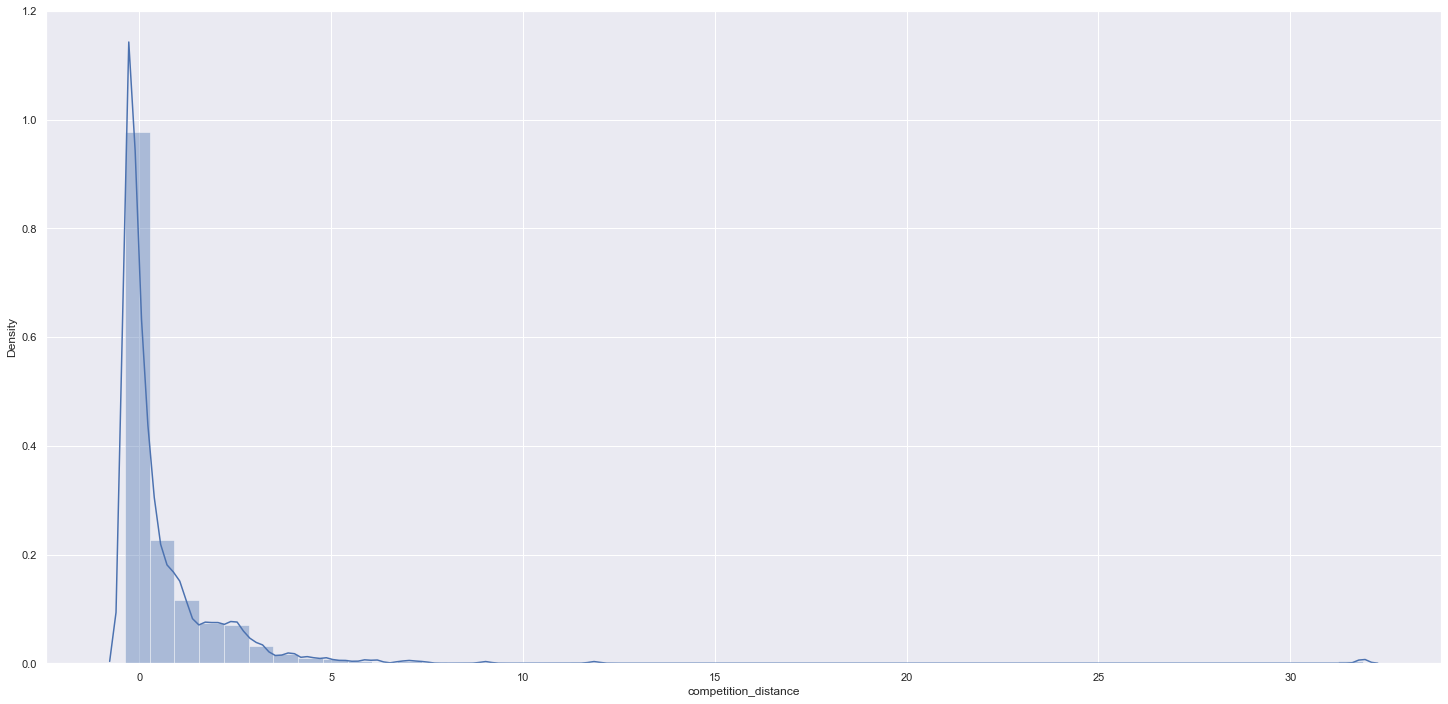

In [70]:
sns.distplot(df5['competition_distance'] );

## 5.3 Transformation

### 5.3.1 Encoding

In [248]:
#state_holiday - One Hot Enconding
df5 = pd.get_dummies( df5, prefix = ['state_holiday'], columns=['state_holiday'])

KeyError: "None of [Index(['state_holiday'], dtype='object')] are in the [columns]"

In [73]:
#store_type
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
##pickle.dump(le, open('/Users/jefersonlima/Desktop/Rossmann Store Sales2/parameter/store_type_scaler.pkl', 'wb') ) 

#assortment
assortment_dict= {'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [74]:
df5.sample(10)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
866553,984,4,2013-05-16,5282,1,0,2,1,-0.304839,5,2013,1,1,2013,0,0.0,5,16,20,2013-19,2013-05-01,-0.216216,2012-12-31,0.330296,0,0,0,1,-0.433884,-0.900969,0.500000,-0.866025,-2.079117e-01,-0.978148,0.663123,-0.748511
361455,864,3,2014-08-20,5106,1,1,0,1,-0.211290,10,2012,1,45,2009,0,0.5,8,20,34,2014-33,2012-10-01,0.081081,2009-11-02,0.856492,0,0,0,1,0.433884,-0.900969,-0.866025,-0.500000,-8.660254e-01,-0.500000,-0.822984,-0.568065
391956,439,5,2014-07-18,7004,1,1,0,1,-0.158065,9,2009,0,29,2014,0,0.5,7,18,29,2014-28,2009-09-01,0.581081,2014-07-14,0.287016,0,0,0,1,-0.974928,-0.222521,-0.500000,-0.866025,-5.877853e-01,-0.809017,-0.354605,-0.935016
955490,721,1,2013-02-25,6420,0,0,0,3,0.203226,9,2012,1,22,2012,0,0.0,2,25,9,2013-08,2012-09-01,-0.148649,2012-05-21,0.378132,0,0,0,1,0.781831,0.623490,0.866025,0.500000,-8.660254e-01,0.500000,0.885456,0.464723
576927,143,4,2014-01-30,4780,0,0,3,1,0.096774,12,2002,0,5,2014,0,0.5,1,30,5,2014-04,2002-12-01,1.608108,2014-01-27,0.287016,0,0,0,1,-0.433884,-0.900969,0.500000,0.866025,-2.449294e-16,1.000000,0.568065,0.822984
695601,627,3,2013-10-16,3685,0,1,2,3,0.264516,3,2010,0,42,2013,0,0.0,10,16,42,2013-41,2010-03-01,0.378378,2013-10-14,0.287016,0,0,0,1,0.433884,-0.900969,-0.866025,0.500000,-2.079117e-01,-0.978148,-0.935016,0.354605
595256,632,2,2014-01-14,5353,0,0,0,1,0.164516,2,2010,0,3,2014,0,0.5,1,14,3,2014-02,2010-02-01,0.432432,2014-01-13,0.287016,0,0,0,1,0.974928,-0.222521,0.500000,0.866025,2.079117e-01,-0.978148,0.354605,0.935016
587851,1032,2,2014-01-21,9124,1,0,3,3,-0.332258,2,2013,1,40,2012,1,0.5,1,21,4,2014-03,2013-02-01,-0.067568,2012-09-24,0.444191,0,0,0,1,0.974928,-0.222521,0.500000,0.866025,-9.510565e-01,-0.309017,0.464723,0.885456
114146,417,1,2015-04-20,5868,0,0,0,3,-0.240323,4,2015,1,10,2014,1,1.0,4,20,17,2015-16,2015-04-01,-0.216216,2014-03-03,0.421412,0,0,0,1,0.781831,0.623490,0.866025,-0.500000,-8.660254e-01,-0.500000,0.885456,-0.464723
1012232,598,6,2013-01-05,6549,0,0,2,1,-0.287097,12,2013,1,40,2014,1,0.0,1,5,1,2013-00,2013-12-01,-0.364865,2014-09-29,0.079727,0,0,0,1,-0.781831,0.623490,0.500000,0.866025,8.660254e-01,0.500000,0.120537,0.992709


###  5.3.2 Response Variable Transformation

In [75]:
df5['sales'] = np.log1p(df5['sales'])

C:\Users\Lima\Anaconda3\envs\Rossmann-Store-Predict-Env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

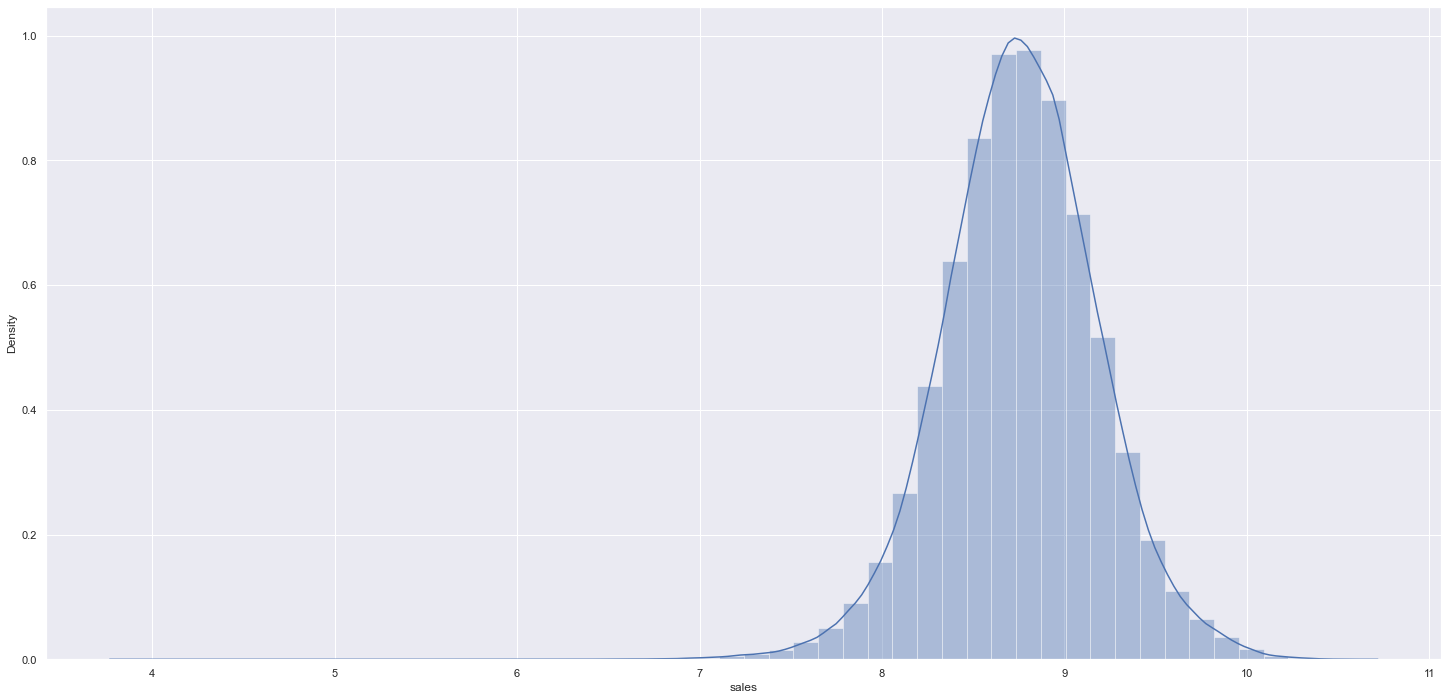

In [76]:
sns.distplot(df5['sales'])

### 5.3.3. Natural Transformation

In [77]:
#day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * ( 2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * ( 2. * np.pi/7)))

#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * ( 2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * ( 2. * np.pi/12)))

#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * ( 2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * ( 2. * np.pi/30)))

#week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * ( 2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * ( 2. * np.pi/52)))

In [78]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0  Feature Selection

In [79]:
df6 = df5.copy()

In [80]:
df6.dtypes 

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                  float64
promo                                    int64
school_holiday                           int64
store_type                               int64
assortment                               int64
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
is_promo                                 int64
year                                   float64
month                                    int64
day                                      int64
week_of_year                             int64
year_week                               object
competition_since               datetime64[ns]
competition_t

In [81]:
#drop columnns duplicated/Derivated
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']

df6 =df6.drop(cols_drop, axis=1)

## 6.1 Slipt DataFrame into Training and Test Dataset

In [82]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=7*6)

Timestamp('2015-06-19 00:00:00')

In [83]:
#Training Dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#Test Dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Trainning Min Date {}'.format(X_train['date'].min()))
print('Trainning Max Date {}'.format(X_train['date'].max()))

print('\nTest Min Date {}'.format(X_test['date'].min()))
print('Test Max Date {}'.format(X_test['date'].max()))



Trainning Min Date 2013-01-01 00:00:00
Trainning Max Date 2015-06-18 00:00:00

Test Min Date 2015-06-19 00:00:00
Test Max Date 2015-07-31 00:00:00


## 6.2 Boruta as Feacture Selector

In [84]:
##Trainning and DataSet for Boruta
#X_train_n = X_train.drop(['date','sales'],axis =1 ).values
#Y_train_n = Y_train.values.ravel()

#define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

#Define Boruta
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42).fit (X_train_n, Y_train_n)

In [85]:
#cols_selected = boruta.support_.tolist()


## Best Dataset Feature Selected
#X_train_fs = X_train.drop(['date','sales'],axis =1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()


#Not Select Boruta
#cols_not_selected_boruta= list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [86]:
#cols_selected_boruta

In [87]:
#cols_not_selected_boruta

## 6.3 Manual Feature Selection

In [88]:
cols_selected_boruta = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 'month_cos','month_sin', 'day_sin', 'day_cos','week_of_year_cos','week_of_year_sin']

In [89]:
#columns to Add
feat_to_add = ['date','sales']

#Final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0 Machine Learning Modelling

In [90]:
df7 = df6.copy()

In [91]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

#Time-Series Prepararion
x_training = X_train[cols_selected_boruta_full]

## 7.1 Average Model

In [92]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns = {'sales': 'predictions'})
aux1 = pd.merge( aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

#performace
baseline_result = m1_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RSME
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2 Linear Regression Model

In [93]:
#model
lr = LinearRegression().fit(x_train, y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performace
lr_result = m1_error('Liner Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RSME
0,Liner Regression,1867.089774,0.292694,2671.049215


## 7.2.1 Linear Regression Model - Cross Validation

In [94]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr , verbose= True)
lr_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RSME CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Linear Regression Regularized Model - Lasso

In [95]:
#model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

#prediction
yhat_lrr = lrr.predict(x_test)

#performace
lrr_result = m1_error('Liner Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RSME
0,Liner Regression - Lasso,1891.704881,0.289106,2744.451737


## 7.3.1 Linear Regression Regularized Lasso  - Cross Validation

In [96]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr , verbose= True)
lrr_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RSME CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 Random Forest Regressor

In [97]:
#model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)

#prediction
yhat_rf = rf.predict(x_test)

#performace
rf_result = m1_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RSME
0,Random Forest Regressor,677.455795,0.099667,1007.9169


## 7.4.1 Random Forest Regressor  - Cross Validation

In [98]:
rs_resul_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf , verbose= True)
rs_resul_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RSME CV
0,Random Forest Regressor,838.23 +/- 218.1,0.12 +/- 0.02,1257.07 +/- 318.2


## 7.5 XGBoost Regressor

In [99]:
#model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                             n_estimators=100, 
                             eta=0.01,         
                             max_depht=10,     
                             subsample=0.7,     
                             colsample_bytee=0.9,  
                            min_child_weight=3 ).fit(x_train, y_train)    

#prediction
yhat_xgb = model_xgb.predict( x_test)

#performace
xgb_result = m1_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

[18:36:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytee", "max_depht" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,Model Name,MAE,MAPE,RSME
0,XGBoost Regressor,6684.971221,0.949058,7335.617326


## 7.5.1 XGBoost Regressor  - Cross Validation

In [100]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb , verbose= False)
xgb_result_cv

[18:38:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytee", "max_depht" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:39:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytee", "max_depht" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:40:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytee", "max_depht" } might not be used.

  This may not 

,Model Name,MAE CV,MAPE CV,RSME CV
0,XGBoost Regressor,7049.48 +/- 589.24,0.95 +/- 0.0,7718.77 +/- 689.68


## 7.6 Compare Model's Performance 

### 7.6.1 Single Performace

In [101]:
modelling_result = pd.concat([baseline_result,lr_result,lrr_result,rf_result,xgb_result])
modelling_result.sort_values('RSME')

,Model Name,MAE,MAPE,RSME
0,Random Forest Regressor,677.455795,0.099667,1007.916900
0,Average Model,1354.800353,0.206400,1835.135542
0,Liner Regression,1867.089774,0.292694,2671.049215
0,Liner Regression - Lasso,1891.704881,0.289106,2744.451737
0,XGBoost Regressor,6684.971221,0.949058,7335.617326


### 7.6.2 Real Performance - Cross Validation

In [204]:
modelling_result_cv= pd.concat([lr_result_cv,lrr_result_cv,rs_resul_cv,xgb_result_cv])
#modelling_result_cv.sort_values('RSME')

modelling_result_cv

,Model Name,MAE CV,MAPE CV,RSME CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,Random Forest Regressor,838.23 +/- 218.1,0.12 +/- 0.02,1257.07 +/- 318.2
0,XGBoost Regressor,7049.48 +/- 589.24,0.95 +/- 0.0,7718.77 +/- 689.68


# 8.0 Hyperameter Fine Tuning

In [ ]:
df8 = df7.copy()

## 8.1 Random Search

In [ ]:
param = {'n_estimators': [1500,1700,300,200], #3500
        'eta': [0.1, 0.03], #0.3
        'max_depht': [3, 5,9], #5
        'subsample': [0.1,0.5,0.7], #0.5
        'colsample_bytee':[0.3,0.5,0.9], #0.9
        'min_child_weight': [3,8,10,11]  #3}

max_eval = 2

In [1]:
#xgb_result = pd.DataFrame()

#for i in range (max_eval):
    #Choose Values for parameters randoly
#    hp = { k: random.sample (v, 1) [0] for k, v in param.items()}
#    print(hp)
#    
#    #model
#    model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                 n_estimators=hp['n_estimators'],
#                                 eta=hp['eta'],
#                                 max_depht=hp['max_depht'],
#                                 subsample=hp['subsample'],
#                                 colsample_bytee=hp['colsample_bytee'],
#                                 min_child_weight=hp['min_child_weight'])
#
#
#   #performace
#    result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb , verbose= True)
#    xgb_result = pd.concat([xgb_result,result])
#                                              
#                                              
#xgb_result

## 8.2 Final Model

In [201]:
param_tuned = {'n_estimators': 3000,
        'eta':0.03,
        'max_depht':5 ,
        'subsample':0.7 ,
        'colsample_bytee': 0.7,
        'min_child_weight': 3 }


In [202]:
##model
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                             n_estimators=param_tuned['n_estimators'],
                             eta=param_tuned['eta'],
                             max_depht=param_tuned['max_depht'],
                             subsample=param_tuned['subsample'],
                             colsample_bytee=param_tuned['colsample_bytee'],
                             min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)

#prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test)

#performace
xgb_result_tuned = m1_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

[18:36:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "colsample_bytee", "max_depht" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,Model Name,MAE,MAPE,RSME
0,XGBoost Regressor,693.763849,0.102824,1000.830591


# 9.0 Traducao e Interpretacao e Erro

In [205]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( yhat_xgb_tuned )

<ipython-input-205-14002072d9da>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['sales'] = np.expm1( df9['sales'] )
<ipython-input-205-14002072d9da>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['predictions'] = np.expm1( yhat_xgb_tuned )


## 9.1. Business Performance


In [206]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby( 'store' ).sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby( 'store' ).apply( lambda x: mean_absolute_percentage_error( x['sales'], x['predictions'] ) ).reset_index().rename( columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [207]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,108367.820312,105025.142630,111710.497995,3342.677683,0.587451
908,909,231773.546875,224097.735691,239449.358059,7675.811184,0.514084
594,595,327588.812500,322139.509713,333038.115287,5449.302787,0.376853
875,876,201384.125000,197435.781760,205332.468240,3948.343240,0.300673
721,722,352241.125000,350269.635373,354212.614627,1971.489627,0.260398


<AxesSubplot:xlabel='store', ylabel='MAPE'>

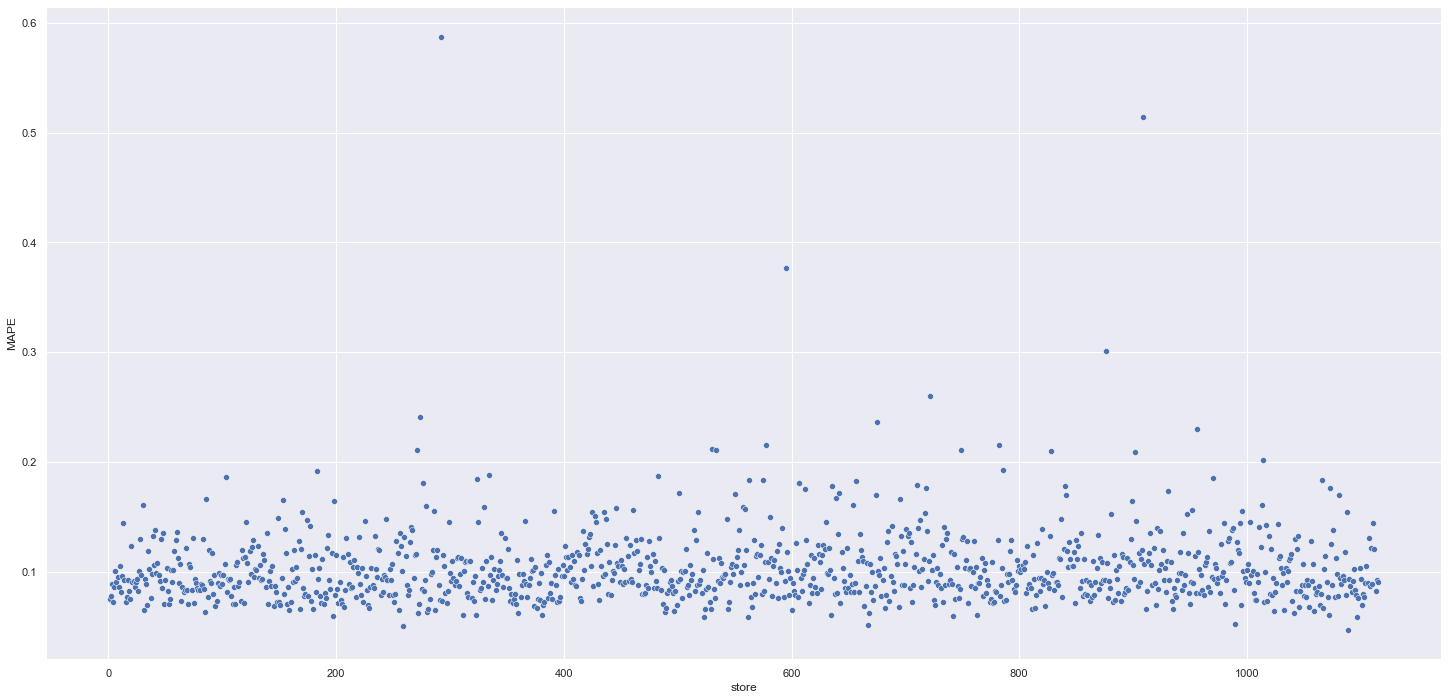

In [208]:
sns.scatterplot( x='store', y='MAPE', data=df92 )

## 9.2. Total Performance


In [209]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x: np.sum( x ), axis=0 ).reset_index().rename( columns={'index': 'Scenario', 0:'Values'} )
df93['Values'] = df93['Values'].map( 'R${:,.2f}'.format )
df93

,Scenario,Values
0,predictions,"R$286,819,584.00"
1,worst_scenario,"R$286,042,386.76"
2,best_scenario,"R$287,596,830.32"


## 9.3. Machine Learning Performance


In [210]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<ipython-input-210-0c99df7e7a2c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error'] = df9['sales'] - df9['predictions']
<ipython-input-210-0c99df7e7a2c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df9['error_rate'] = df9['predictions'] / df9['sales']


C:\Users\Lima\Anaconda3\envs\Rossmann-Store-Predict-Env\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\Lima\Anaconda3\envs\Rossmann-Store-Predict-Env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='predictions', ylabel='error'>

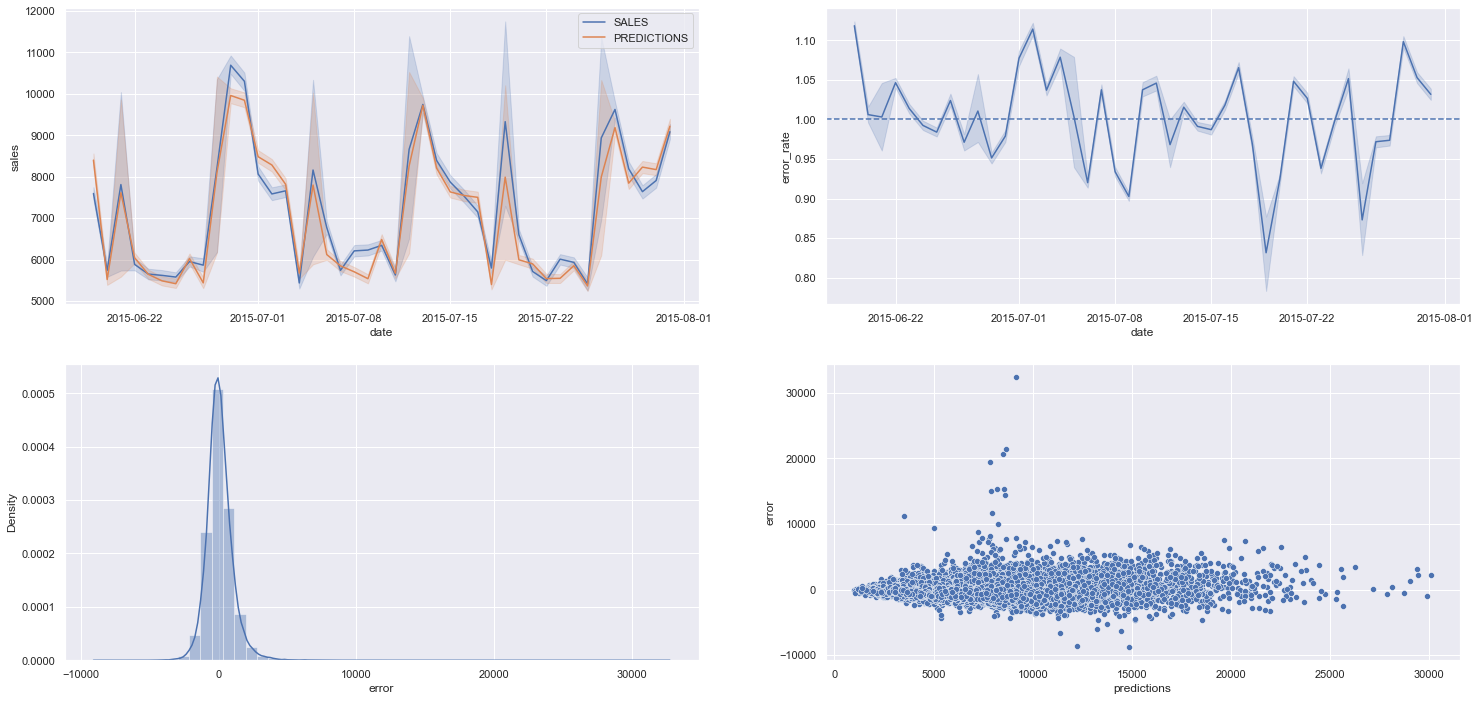

In [211]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )

# 10.0 Deploy Model to Production

In [ ]:
# Save Trained Model
pickle.dump( model_xgb_tuned, open( '/Users/meigarom/repos/DataScience_Em_Producao/model/model_rossmann.pkl', 'wb' ) )

## 10.1 Class Rossmann

In [120]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann (object ): 
    def __init__(self):
        state = 1
        self.competition_distance_scaler = pickle.load(open('/Users/jefersonlima/Desktop/Rossmann Store Sales2/parameter/competition_distance_scaler.pkl', 'rb') ) 
        self.competition_time_month_scaler = pickle.load(open('/Users/jefersonlima/Desktop/Rossmann Store Sales2/parameter/competition_time_month_scaler.pkl', 'rb') ) 
        self.promo_time_week_scaler = pickle.load(open('/Users/jefersonlima/Desktop/Rossmann Store Sales2/parameter/promo_time_week_scaler.pkl', 'rb') ) 
        self.year_scaler = pickle.load(open('/Users/jefersonlima/Desktop/Rossmann Store Sales2/parameter/year_scaler.pkl', 'rb') ) 
        self.store_type_scaler = pickle.load(open('/Users/jefersonlima/Desktop/Rossmann Store Sales2/parameter/store_type_scaler.pkl', 'rb') ) 
        self.year_scaler = pickle.load(open('/Users/jefersonlima/Desktop/Rossmann Store Sales2/parameter/year_scaler.pkl', 'rb') ) 


        
    def data_cleaning(self,df1):

        ## 1.1. Rename Columns

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
                    'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear',
                    'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list(map(snakecase, cols_old))

        #Rename
        df1.columns = cols_new

        ## 1.3. Data Type
        #mudando DateTime
        df1['date'] = pd.to_datetime(df1['date'])

        ## 1.4. Check NA
        ## 1.5. Fill out NA

        df1['competition_distance'].max()


        #competition_distance    
        df1['competition_distance'] = df1['competition_distance'].apply (lambda x: 200000.0 if math.isnan(x) else x)

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply (lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        #competition_open_since_year   
        df1['competition_open_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

        #promo2_since_week 
        df1['promo2_since_week'] = df1.apply (lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

        #promo2_since_year  
        df1['promo2_since_year'] = df1.apply (lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        #promo_interval 
        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Ago', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace=True)

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)


        ## 1.6 Change Dtypes

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        
        return df1



    def feature_engineering(self,df2):


        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        # year week
        df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

        # competition since
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year=x['competition_open_since_year'], 
                                                                          month=x['competition_open_since_month'],day=1 ), axis=1 )

        df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30 ).apply( lambda x: x.days ).astype( int )

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
        df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
        df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply( lambda x: x.days ).astype( int )

        # assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' 
                                                          else 'christmas' if x == 'c' else 'regular_day' )

        # 3.0. Filtragem de Variaveis

        ## 3.1. Filtragem das Linhas

        df2 = df2[(df2['open'] != 0)]

        ## 3.2. Selecao das Colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df2 = df2.drop( cols_drop, axis=1 )
        
        return df2

    def data_preparation(self,df5):

        ## 5.1 Normalization

        ## 5.2 Rescaling

        #competition_distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

        #competition_time_month
        df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df5[['competition_time_month']].values)


        #promo_time_week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df5[['promo_time_week']].values)

        #year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        ## 5.3 Transformation

        ### 5.3.1 Encoding


        #state_holiday - One Hot Enconding
        df5 = pd.get_dummies( df5, prefix = ['state_holiday'], columns=['state_holiday'])


        #store_type
        le = LabelEncoder()
        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

        #assortment
        assortment_dict= {'basic':1, 'extra':2, 'extended':3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        ### 5.3.3. Natural Transformation
        #day_of_week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * ( 2. * np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * ( 2. * np.pi/7)))

        #month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * ( 2. * np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * ( 2. * np.pi/12)))

        #day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * ( 2. * np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * ( 2. * np.pi/30)))

        #week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * ( 2. * np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * ( 2. * np.pi/52)))
        
        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month', 'competition_open_since_year', 
                                'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week', 'day_of_week_sin', 'day_of_week_cos', 
                                'month_cos','month_sin', 'day_sin', 'day_cos','week_of_year_cos','week_of_year_sin']
        
        return df5[cols_selected]

    
    def get_prediction(self, model, original_data, test_data):
        #prediction
        pred = model.predict(test_data)
        
        #join pred into original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records',date_format='iso')

## 10.2 API Handler

In [137]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

#loading Model
mac model = pickle.load(open('/Users/jefersonlima/Desktop/Rossmann Store Sales2/Rossmann.pkl', 'rb') )

#Inicialize API
app = Flask (__name__)

@app.route('/rossmann/predict', methods=['POST'])
def rossmann_predict():
    test_json = request.get_json()

    if test_json: #there is data
        if isinstance (test_json, dict): #Unique Example
            test_raw = pd.DataFrame(test_json, index=[0])
            
        else: #Multiple Example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys() )

        
        #instance
        pipeline = Rossmann()
        
        #data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        #feature engineering
        df2 = pipeline.feature_engineering(df1)
        #data preparation
        df3 = pipeline.data_preparation(df2)

        #prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
        
        
        
    else:
        return response ('{}', status=200, mimetype='application/json')

if __name == '__main__':
    app.run('0.0.0.0')

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (<ipython-input-137-c53d5676b321>, line 9)

## 10.3 API Tester

In [19]:
import requests
import json

In [20]:
#loading test
df10 = pd.read_csv ('../rossmann-telegram-api/test.csv', low_memory=False)

In [21]:
#merge test dataset + store
df_test = pd.merge(df10,df_store_raw,how ='left', on='Store')

#choose Store for Predictions
df_test = df_test[df_test['Store'].isin([40])]

#remove closed days
df_test = df_test[df_test['Open']!= 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)



In [22]:
#convert DataFrame to Json

data = json.dumps(df_test.to_dict(orient='records'))

In [27]:
#API Call

#url='http://0.0.0.0:5000/rossmann/predict' #url-local

url='https://rossmann-model-testjl.herokuapp.com/rossmann/predict'
header={'Content-Type': 'application/json'}
data= data

r = requests.post(url,data=data,headers=header)
print('Status Code {}'.format( r.status_code))

Status Code 200


In [28]:
d1 = pd.DataFrame (r.json(), columns=r.json()[0].keys())

In [29]:
d1.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,prediction
0,40,4,2015-09-17T00:00:00.000Z,1.0,1,regular_day,0,a,basic,180.0,9,2015,1,45,2009,"Feb,May,Aug,Nov",Sep,0,2015,9,17,38,2015-37,2015-09-01T00:00:00.000Z,0,2009-11-02T00:00:00.000Z,306,4492.760742
1,40,3,2015-09-16T00:00:00.000Z,1.0,1,regular_day,0,a,basic,180.0,9,2015,1,45,2009,"Feb,May,Aug,Nov",Sep,0,2015,9,16,38,2015-37,2015-09-01T00:00:00.000Z,0,2009-11-02T00:00:00.000Z,306,4601.815430
2,40,2,2015-09-15T00:00:00.000Z,1.0,1,regular_day,0,a,basic,180.0,9,2015,1,45,2009,"Feb,May,Aug,Nov",Sep,0,2015,9,15,38,2015-37,2015-09-01T00:00:00.000Z,0,2009-11-02T00:00:00.000Z,306,5417.556641
3,40,1,2015-09-14T00:00:00.000Z,1.0,1,regular_day,0,a,basic,180.0,9,2015,1,45,2009,"Feb,May,Aug,Nov",Sep,0,2015,9,14,38,2015-37,2015-09-01T00:00:00.000Z,0,2009-11-02T00:00:00.000Z,306,6226.840820
4,40,6,2015-09-12T00:00:00.000Z,1.0,0,regular_day,0,a,basic,180.0,9,2015,1,45,2009,"Feb,May,Aug,Nov",Sep,0,2015,9,12,37,2015-36,2015-09-01T00:00:00.000Z,0,2009-11-02T00:00:00.000Z,305,2782.403809


In [26]:
d2 =d1[['store','prediction']].groupby('store').sum().reset_index()

for i in range( len(d2)):
    print('Store Number {} will sell R${:,.2f} in the next 6 weeks' .format(d2.loc[i, 'store'],
                                                                     d2.loc[i, 'prediction']))

Store Number 40 will sell R$160,845.80 in the next 6 weeks
